In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../../')

#from main import load_and_prepare_sessions
import create_cpt_sessions
import create_oft_sessions
import config
from processing.combine_session_timestamps import update_phot_dfs_with_timestamps 

In [3]:
# cpt_sessions = create_cpt_sessions.create_pickle('../../../Dual_Sensor_CPT/Males_redo', None)

In [4]:
oft_sessions_1 = create_oft_sessions.create_pickle('../../../GqCoh1And2_OFT/First Test Round', None)

100%|██████████| 13/13 [00:17<00:00,  1.33s/it]


In [5]:
oft_sessions_2 = create_oft_sessions.create_pickle('../../../GqCoh1And2_OFT/Second Test Round', None)

100%|██████████| 13/13 [00:14<00:00,  1.08s/it]


In [6]:
oft_sessions = oft_sessions_1 + oft_sessions_2

In [7]:
oft_sessions = [session for session in oft_sessions if session.mouse_id != '81']

In [8]:
all_genotypes = set([session.genotype for session in oft_sessions])

In [9]:
mice_gen_dict = {
    69: "Cre",
    71: "WT",
    73: "Cre",
    75: "WT",
    77: "Cre",
    79: "WT",
    85: "WT",
    87: "WT",
    135: "WT",
    137: "WT",
    139: "Cre",
    133: "WT",
    127: "WT",
    125: "WT",
    129: "Cre",
    131: "WT",
    143: "Cre",
    145: "WT",
    147: "WT",
    157: "Cre",
    159: "Cre",
    161: "WT",
    171: "Cre",
    173: "Cre"
}

geno_mapping = {
    "Cre": "TH-Cre",
    "WT": "Wildtype"
}
mice_gen_dict = {k: geno_mapping[v] for k, v in mice_gen_dict.items()}

In [10]:
for session in oft_sessions:
    int_id = int(session.mouse_id)
    if int_id in mice_gen_dict:
        session.genotype = mice_gen_dict[int_id]

In [11]:
for session in oft_sessions:
    print(session.mouse_id, session.genotype)

69 TH-Cre
71 Wildtype
73 TH-Cre
75 Wildtype
77 TH-Cre
79 Wildtype
83 TH-Cre
85 Wildtype
87 Wildtype
127 Wildtype
125 Wildtype
129 TH-Cre
131 Wildtype
135 Wildtype
137 Wildtype
139 TH-Cre
133 Wildtype
143 TH-Cre
145 Wildtype
147 Wildtype
157 TH-Cre
159 TH-Cre
161 Wildtype
171 TH-Cre
173 TH-Cre
69 TH-Cre
71 Wildtype
73 TH-Cre
75 Wildtype
77 TH-Cre
79 Wildtype
83 TH-Cre
85 Wildtype
87 Wildtype
127 Wildtype
125 Wildtype
135 Wildtype
137 Wildtype
139 TH-Cre
133 Wildtype
129 TH-Cre
131 Wildtype
143 TH-Cre
145 Wildtype
147 Wildtype
157 TH-Cre
159 TH-Cre
161 Wildtype
171 TH-Cre
173 TH-Cre


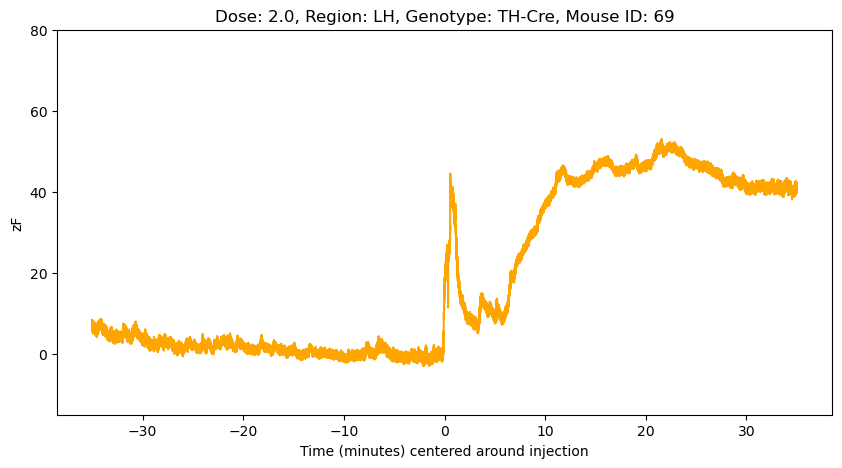

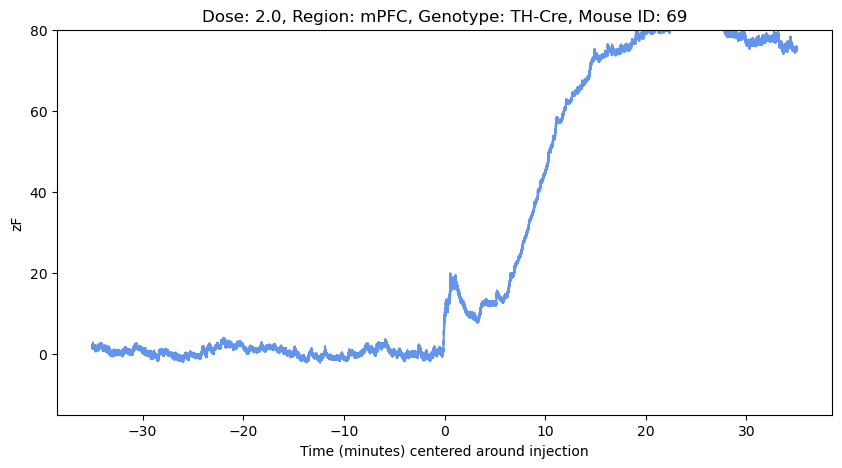

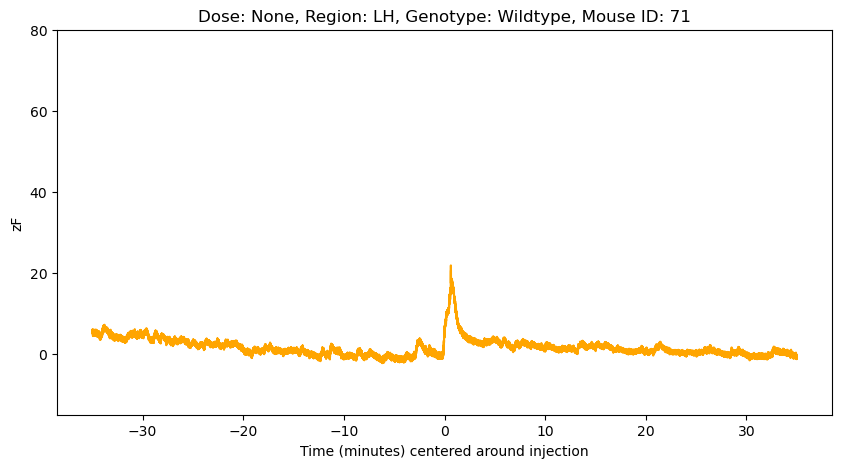

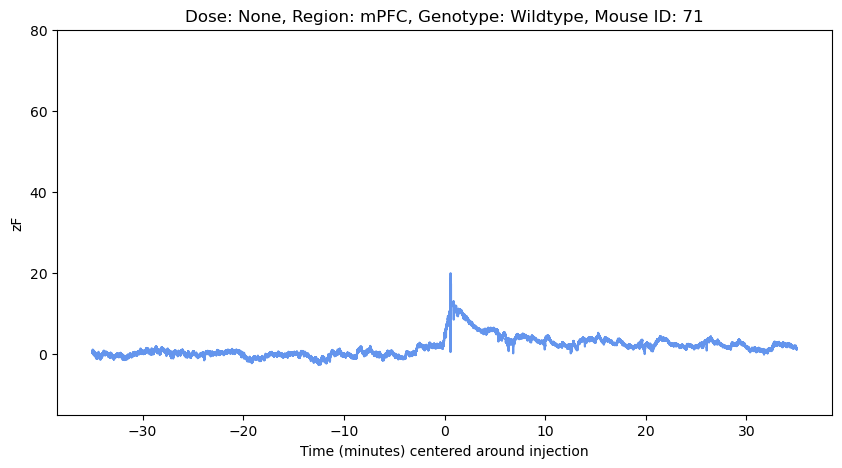

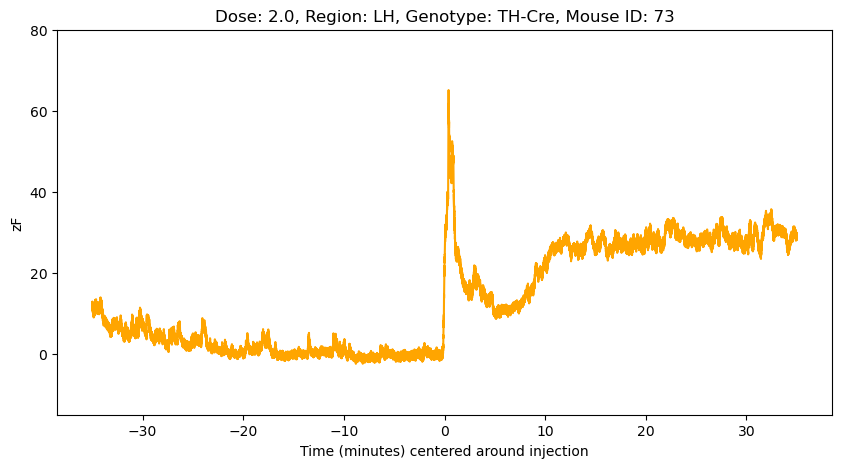

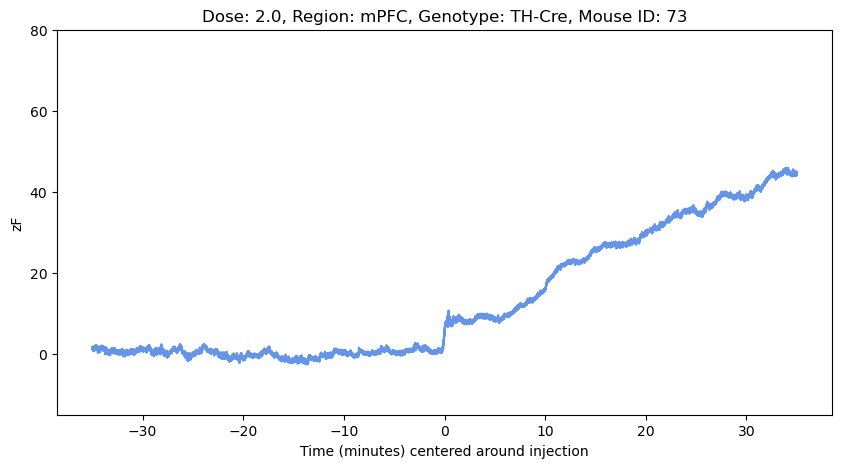

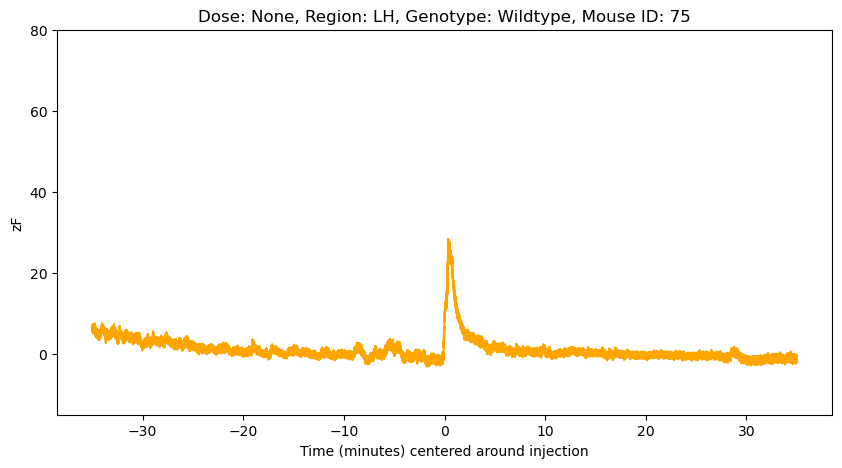

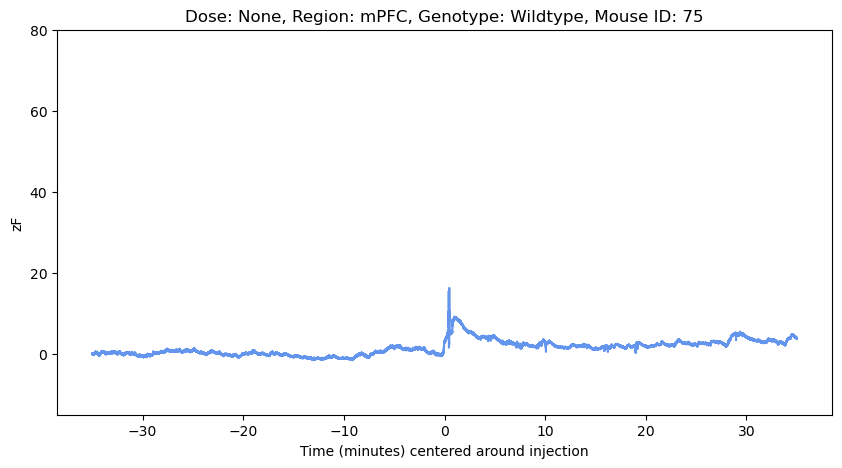

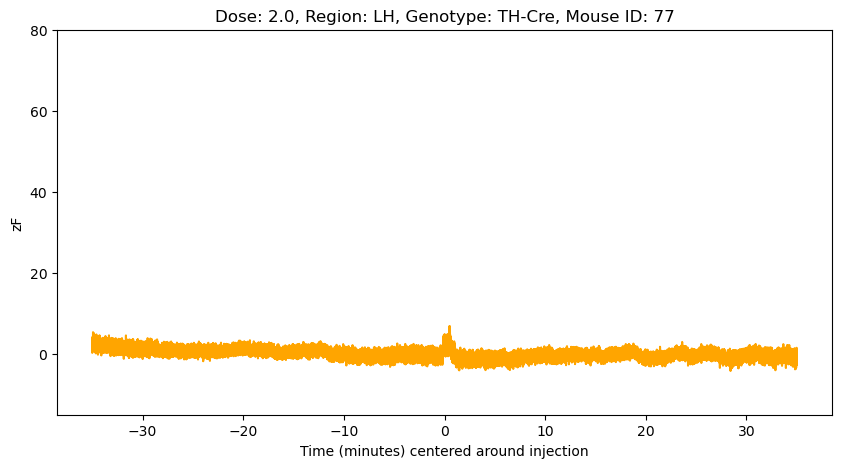

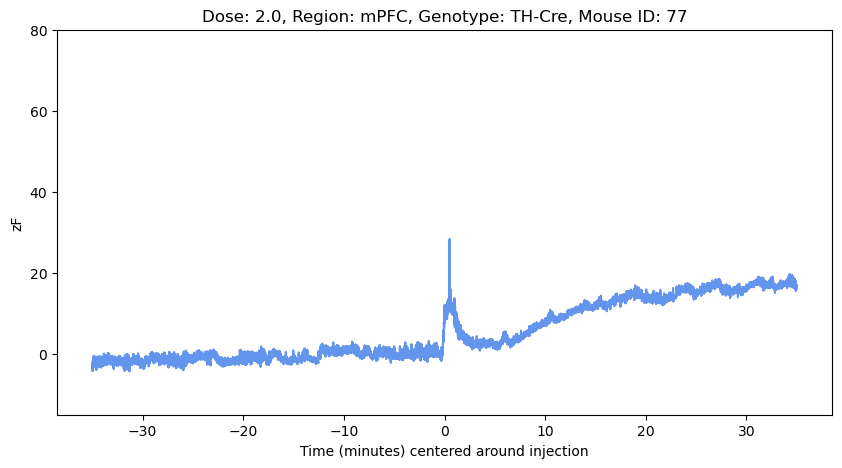

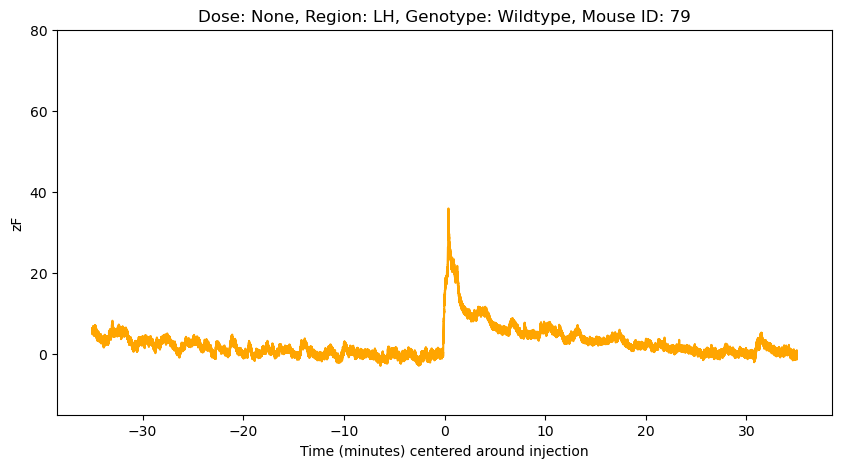

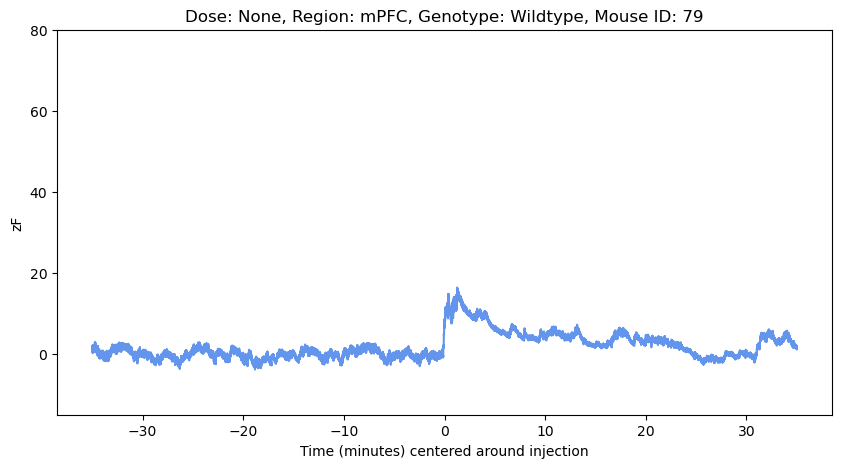

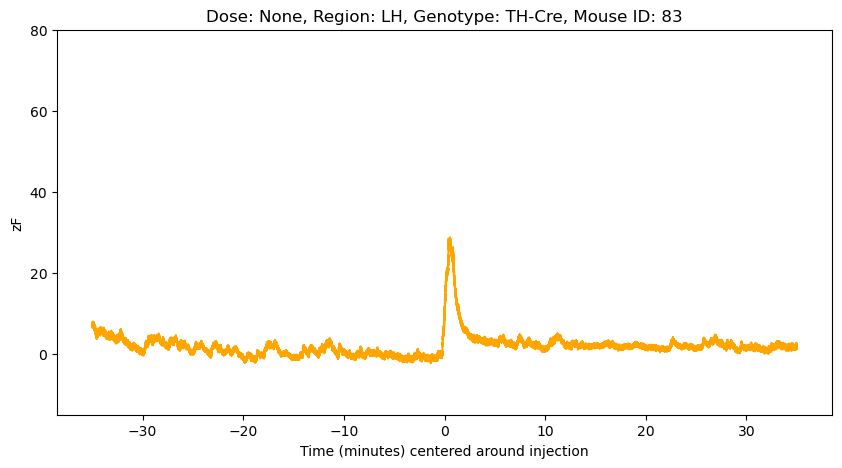

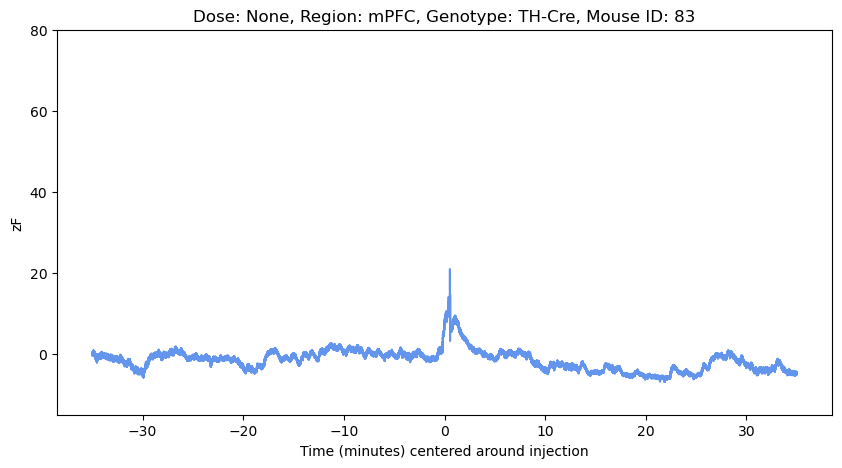

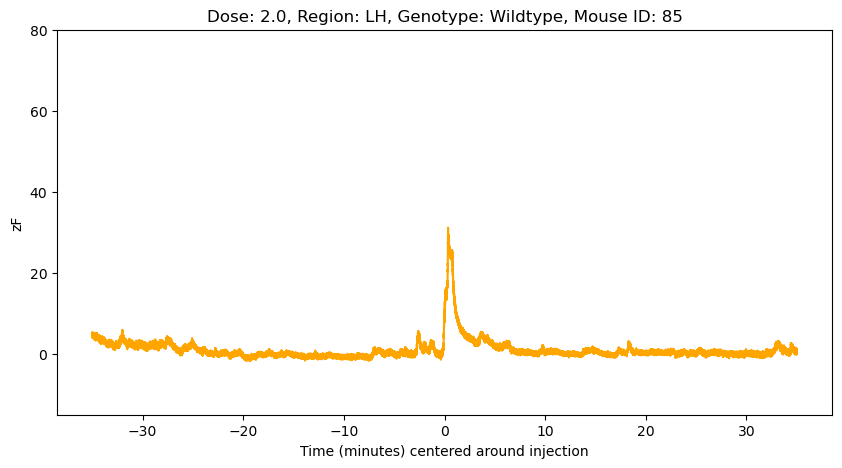

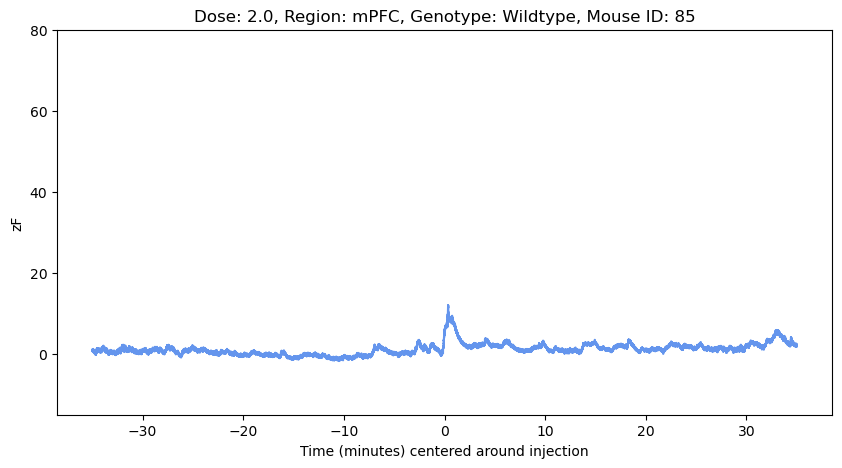

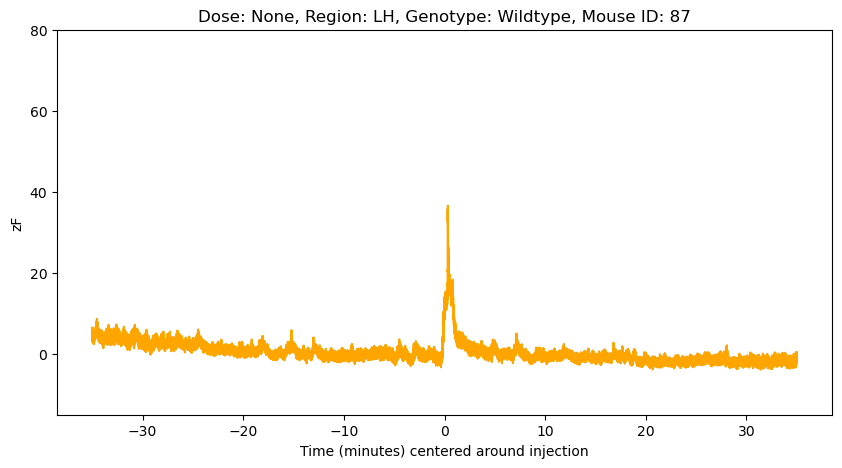

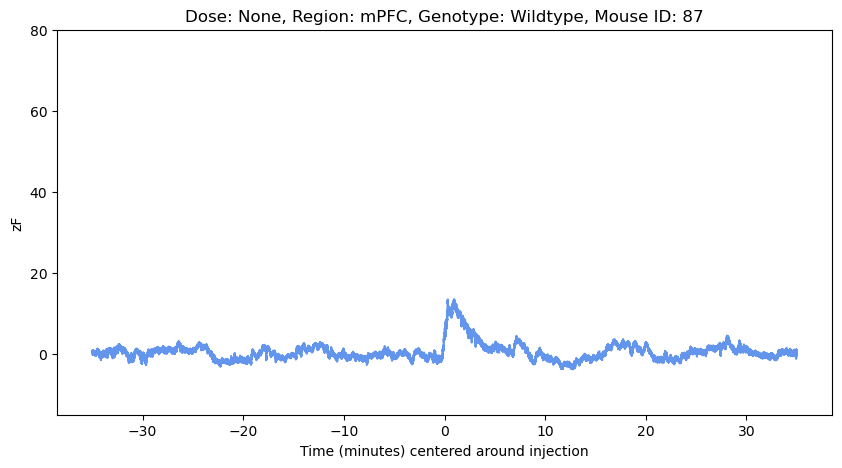

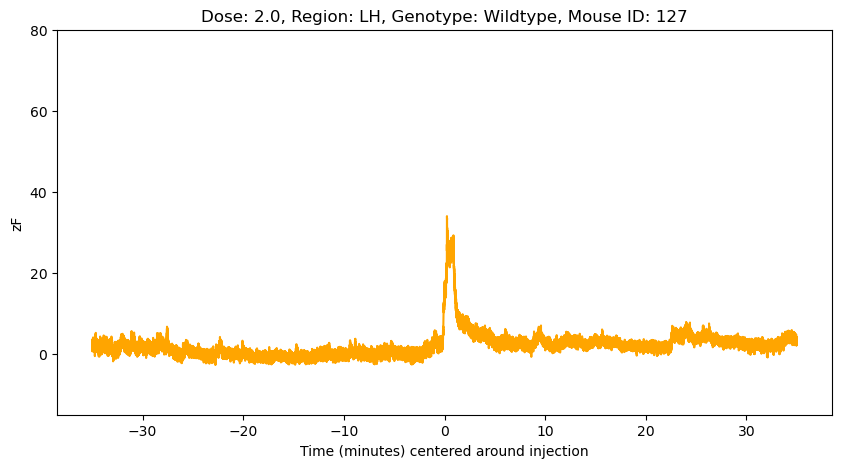

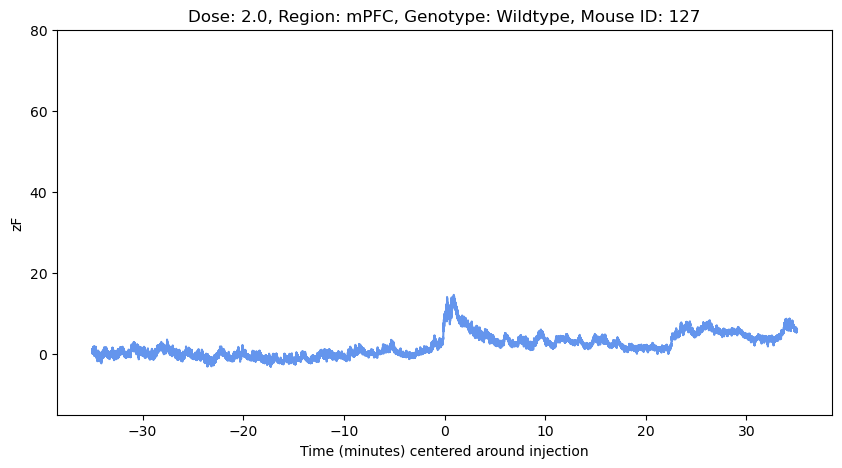

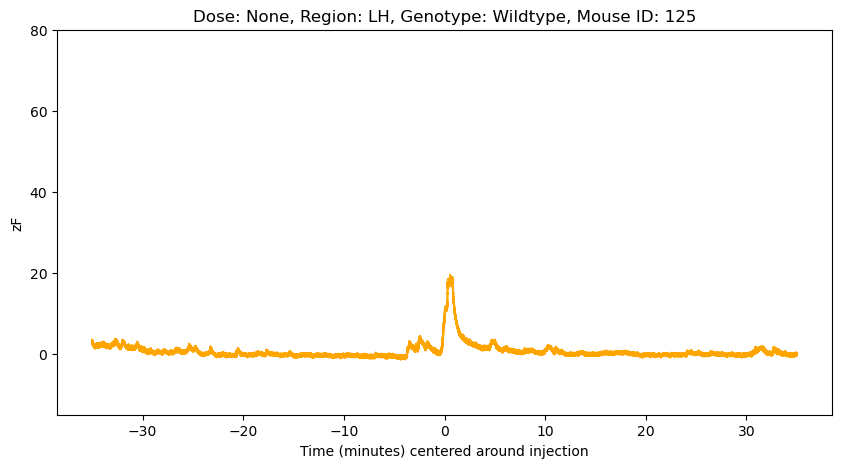

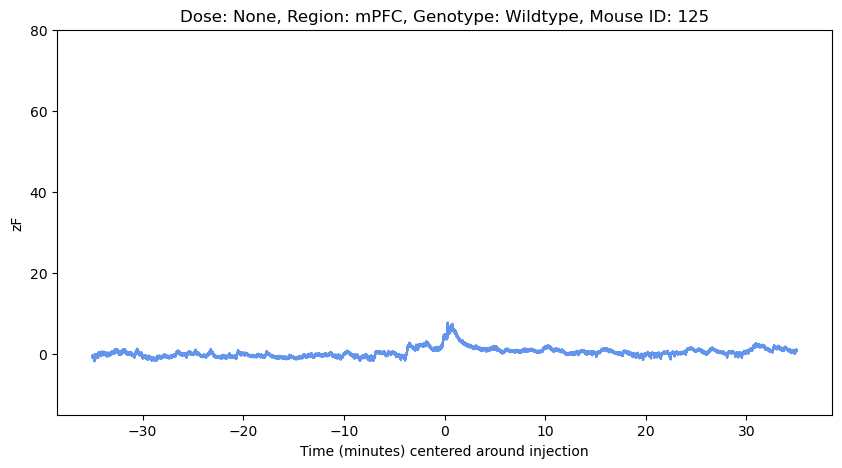

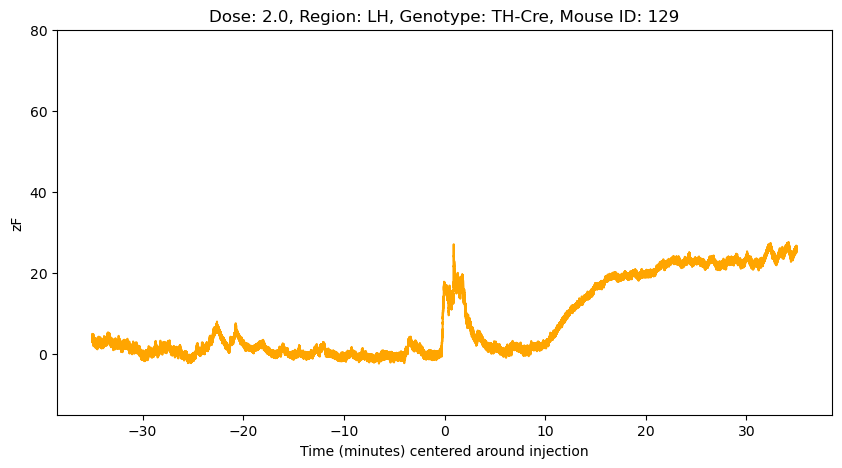

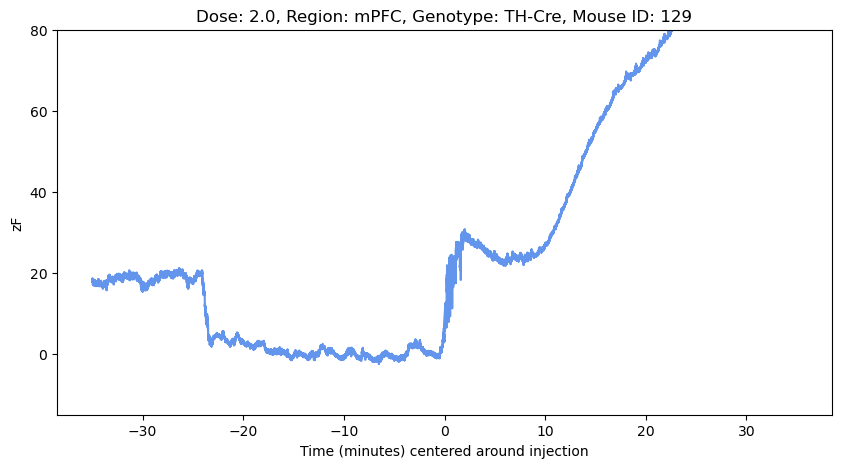

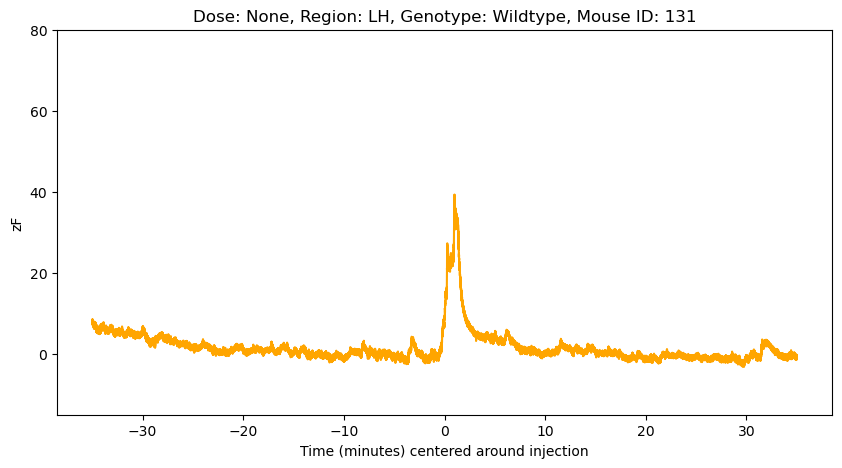

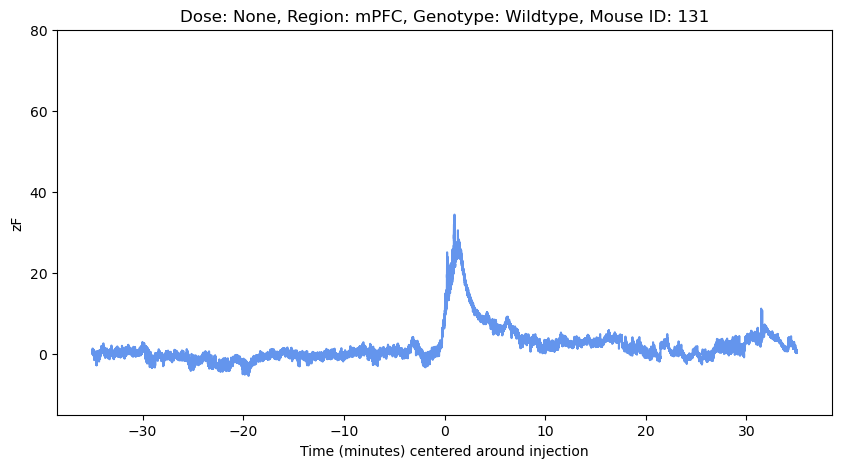

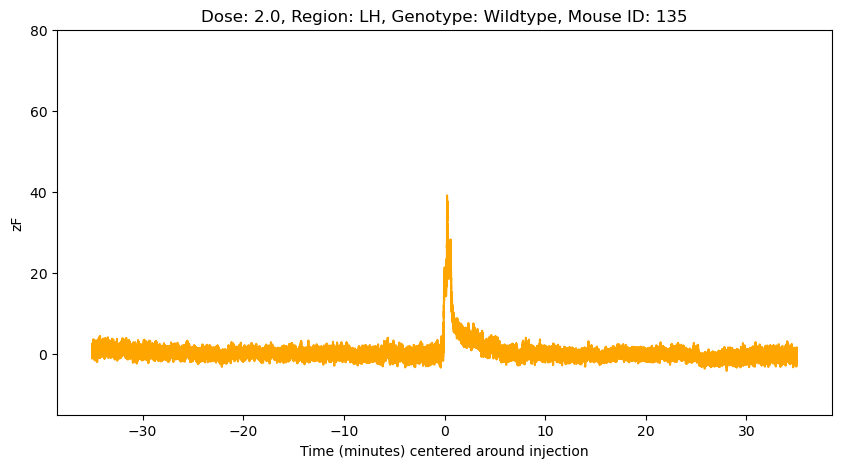

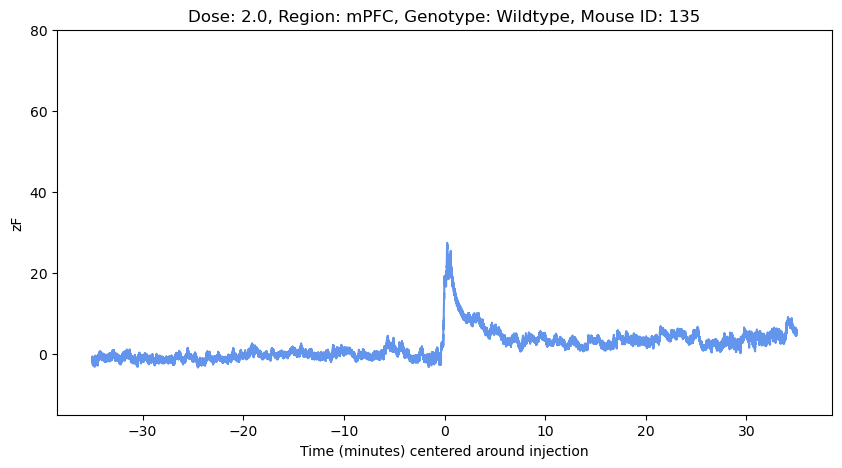

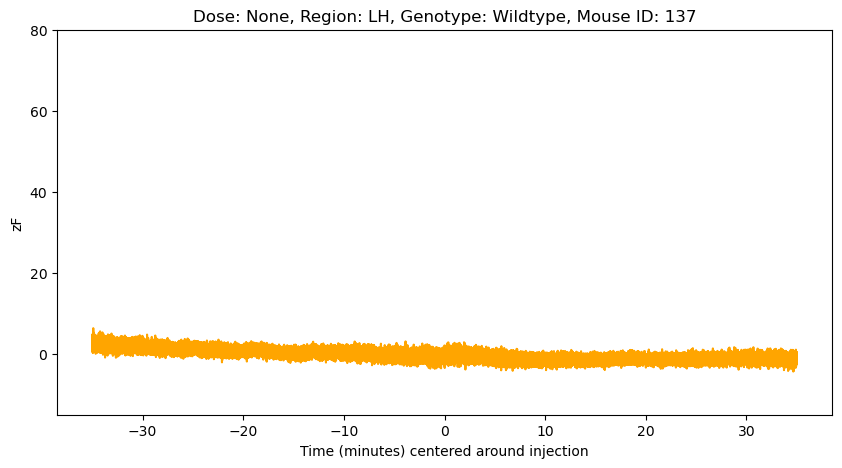

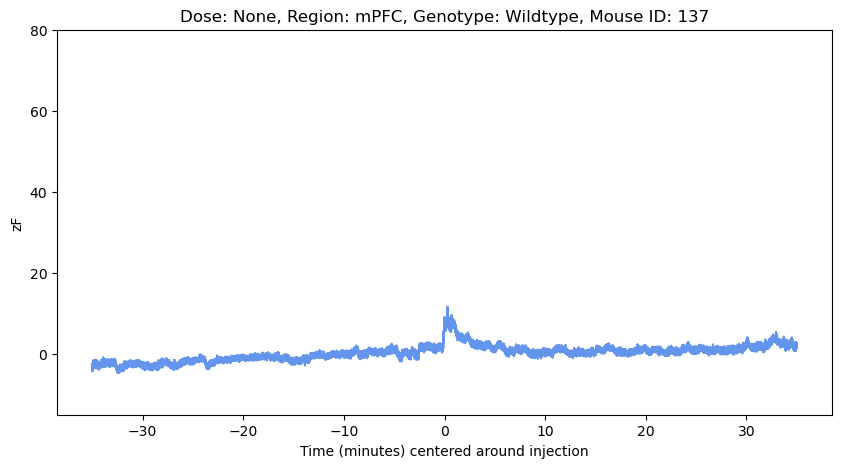

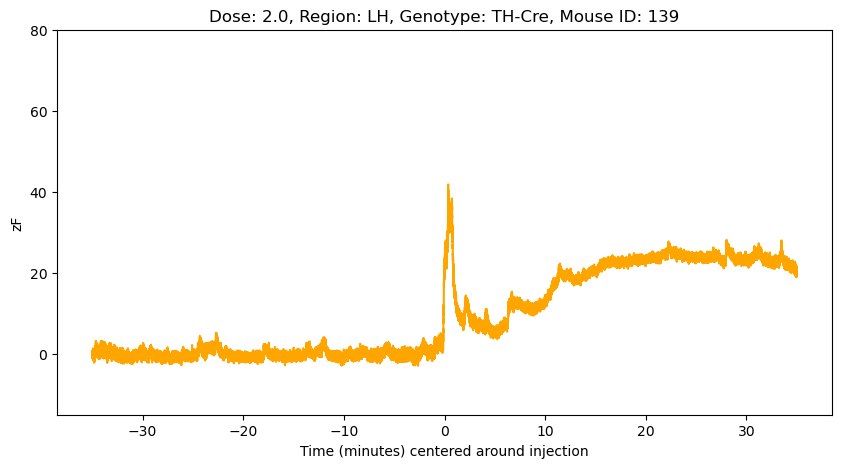

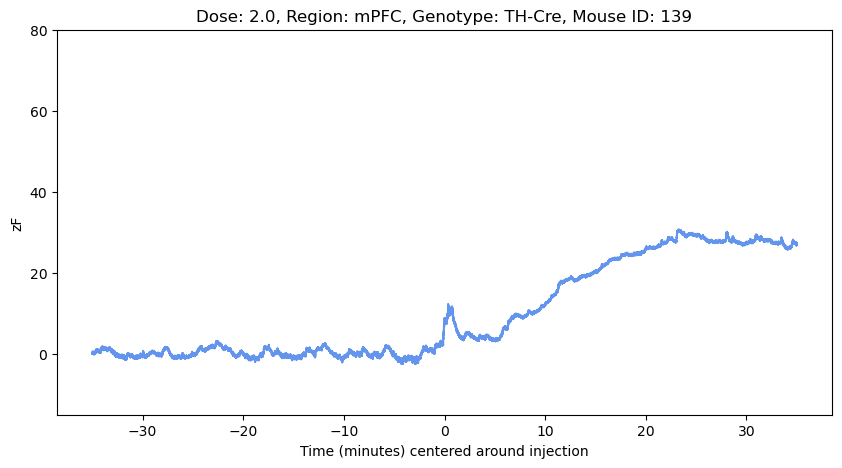

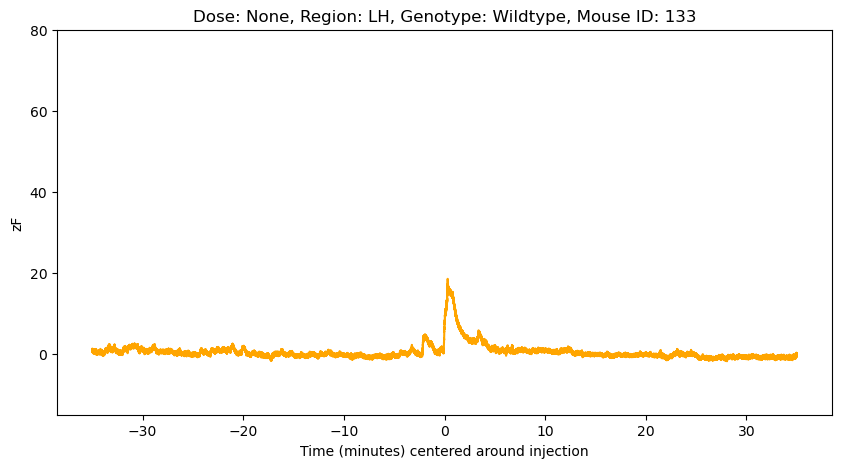

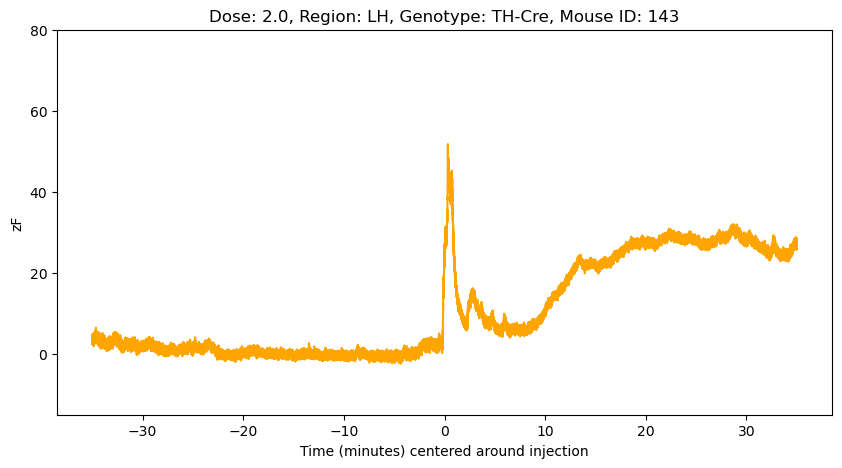

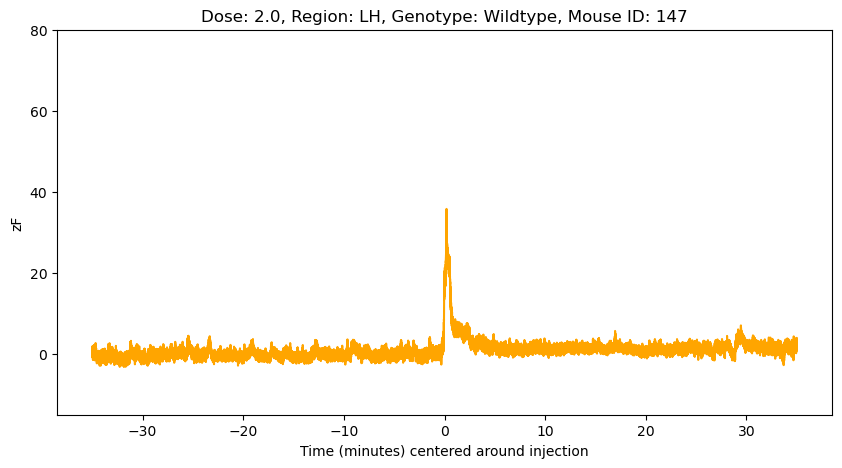

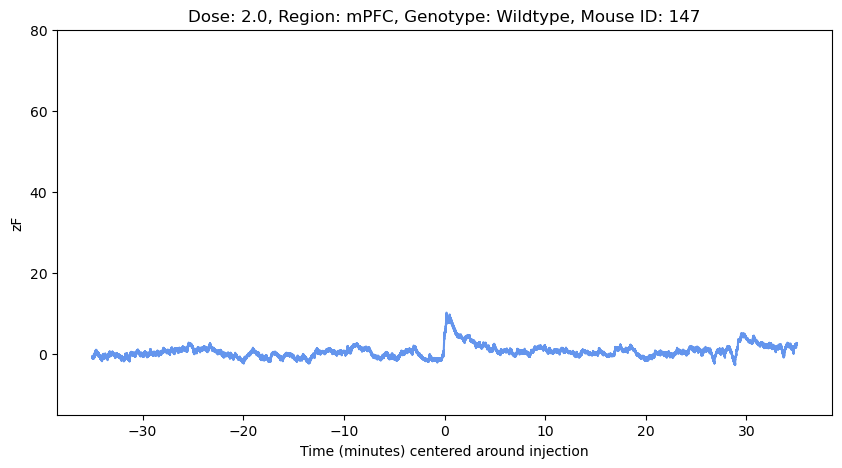

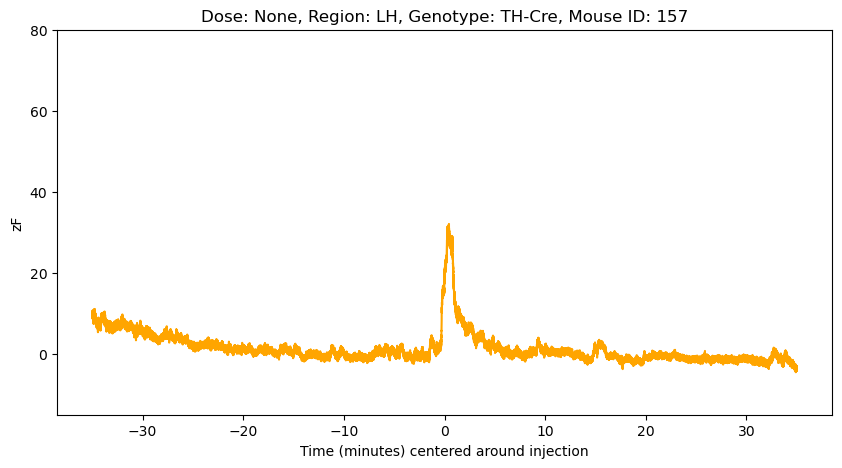

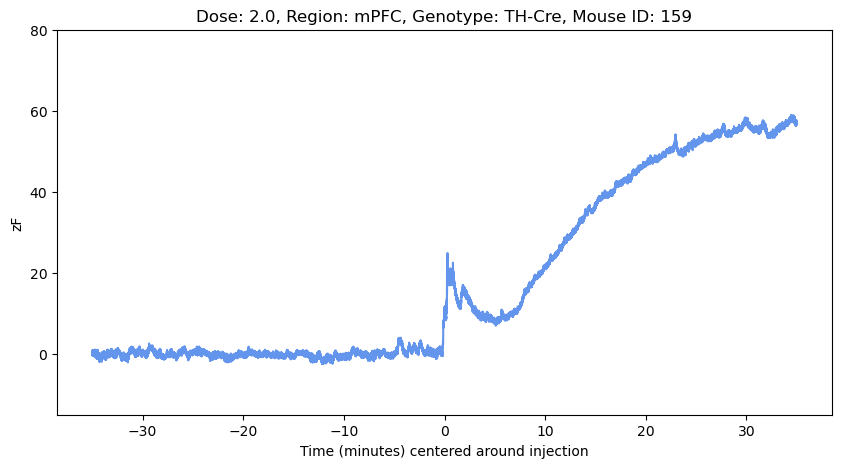

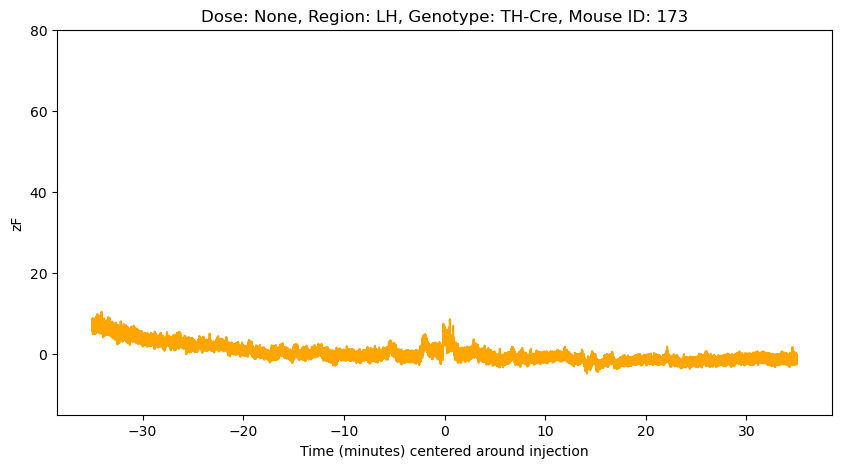

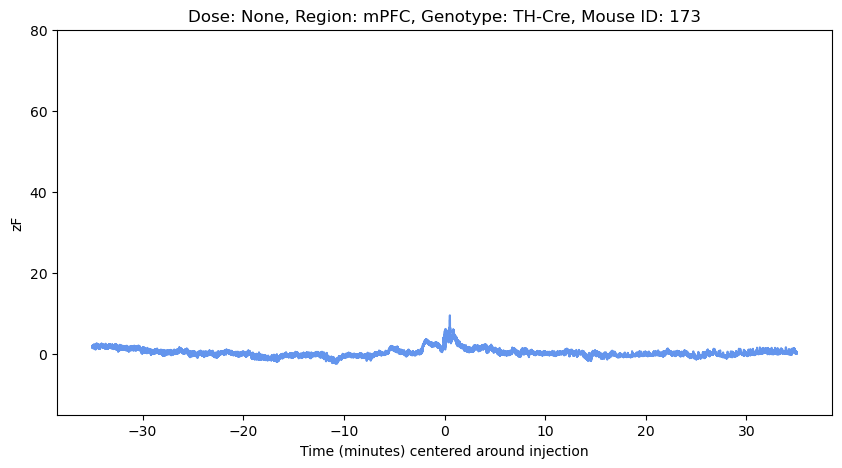

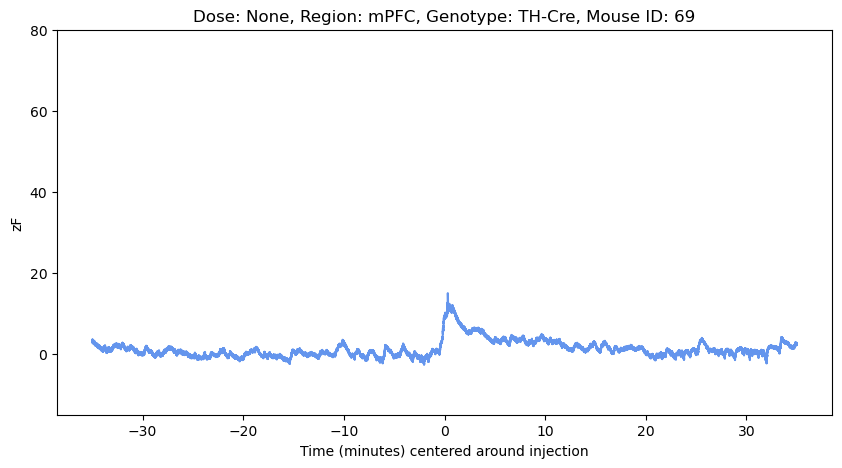

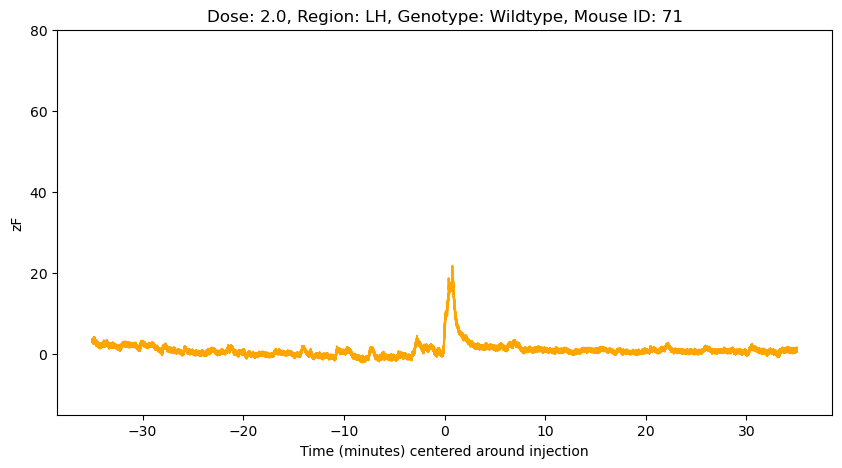

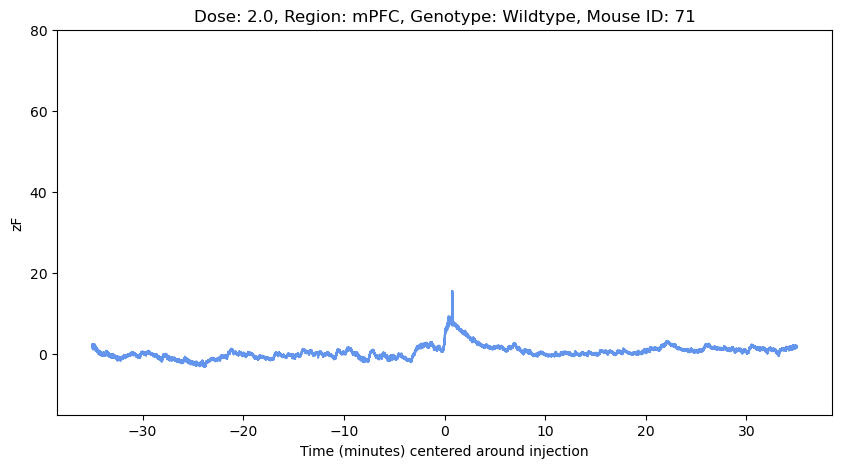

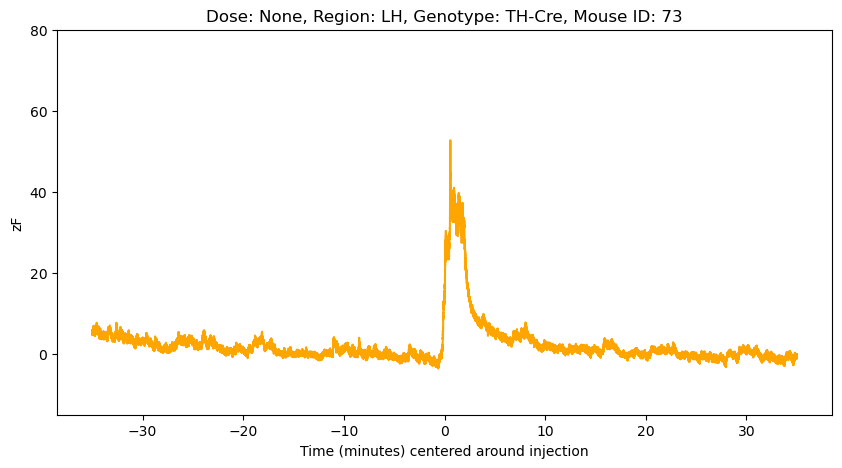

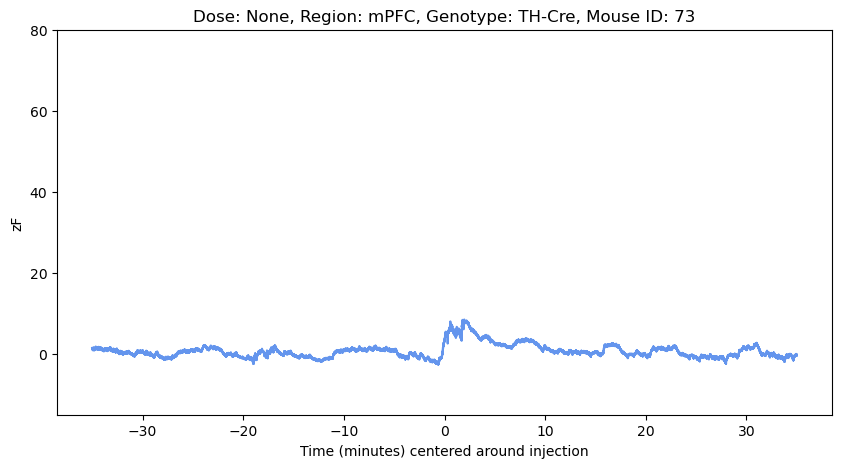

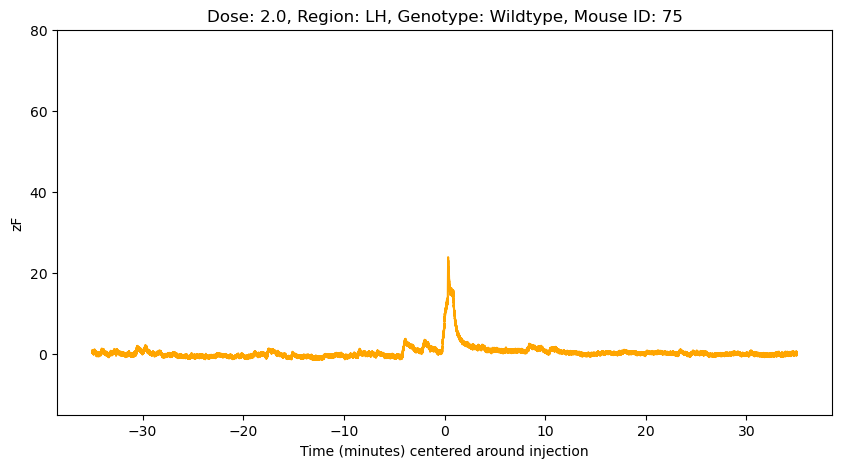

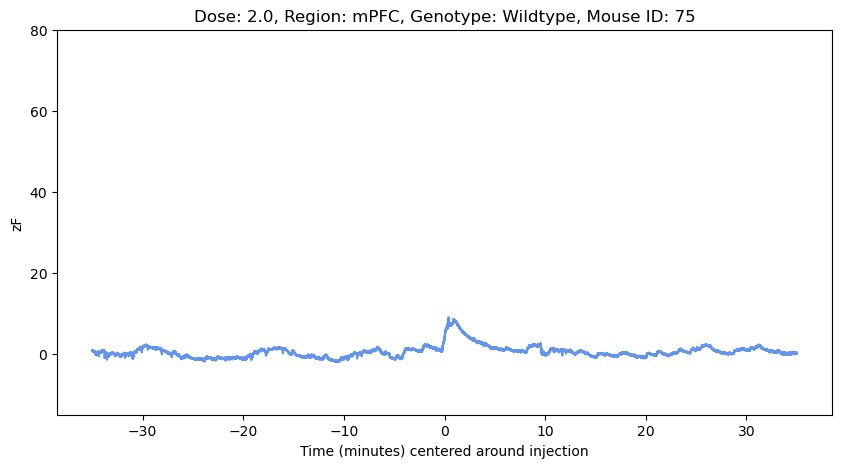

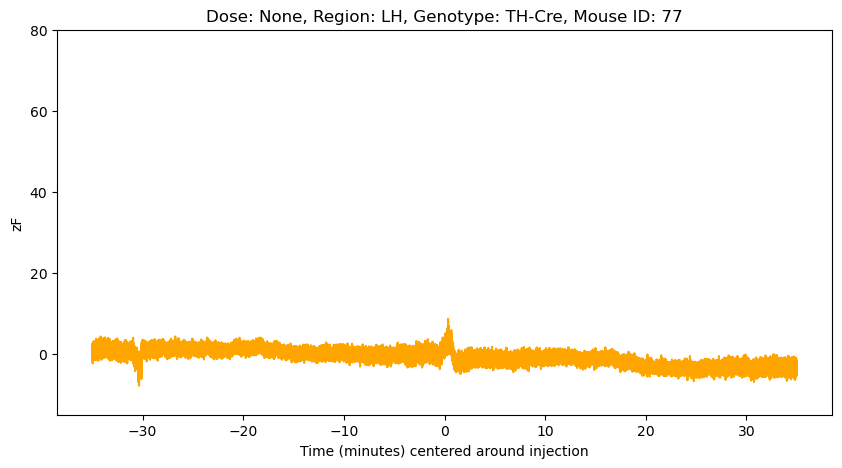

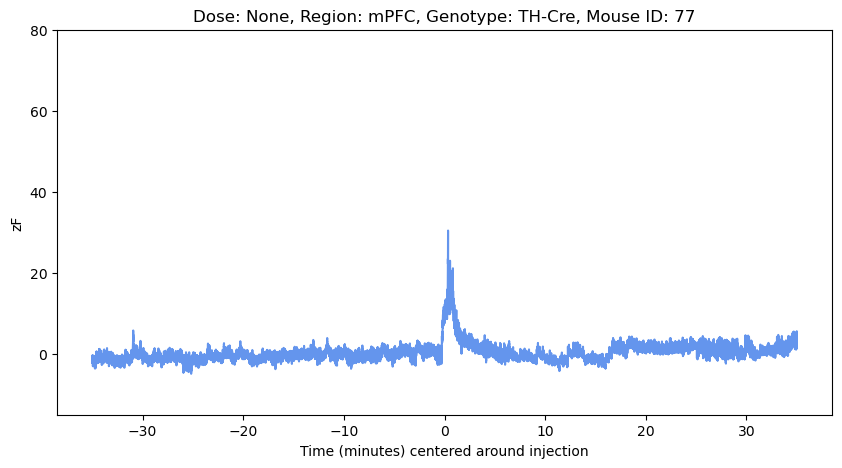

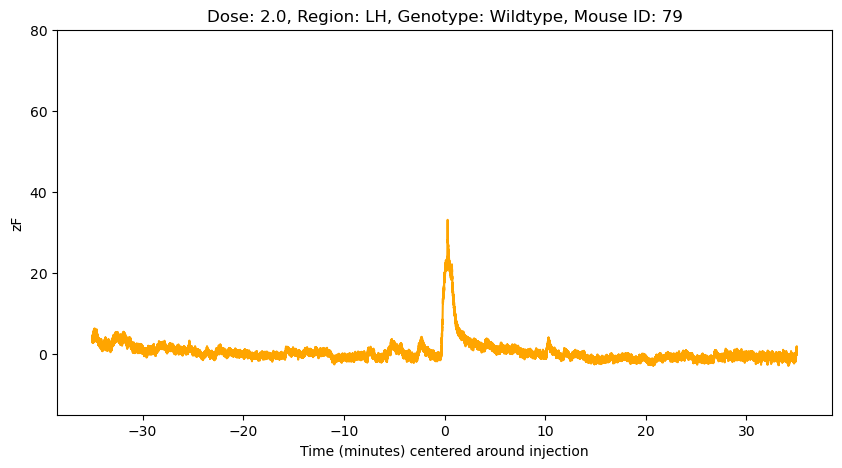

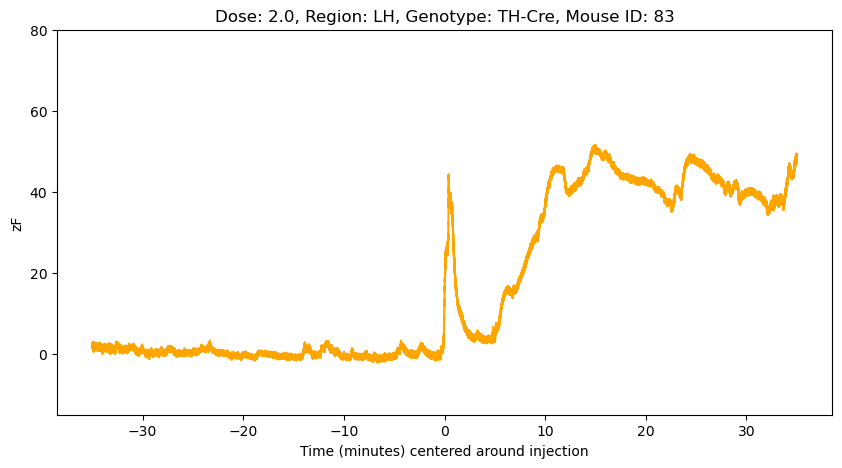

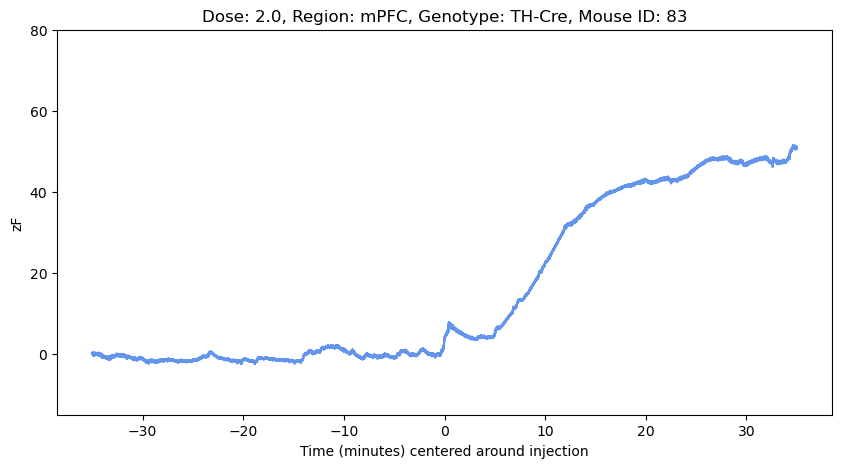

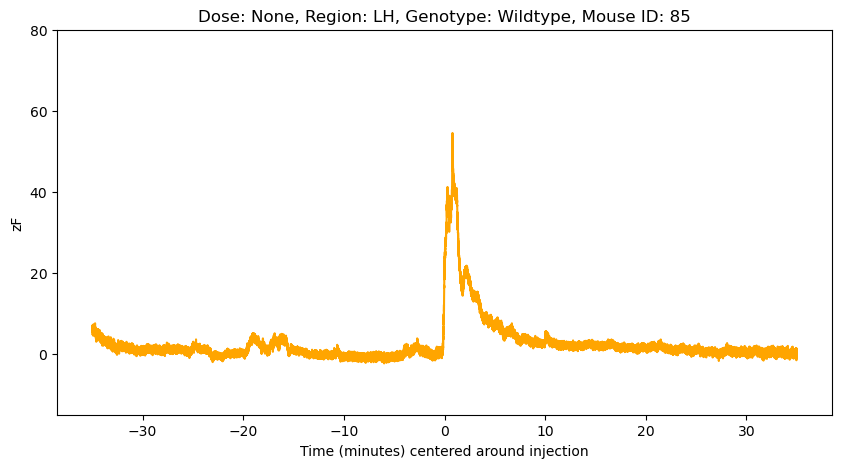

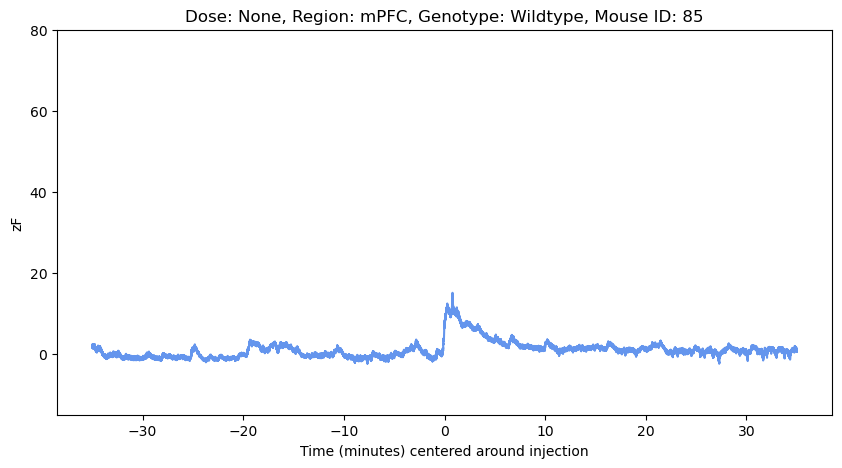

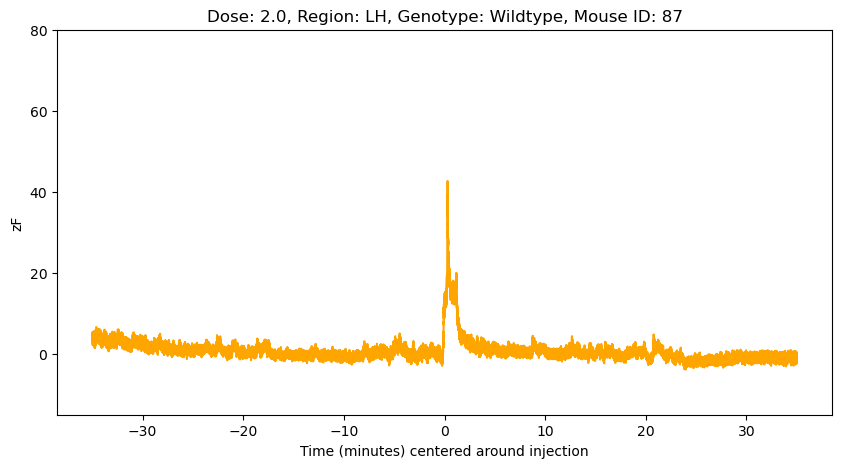

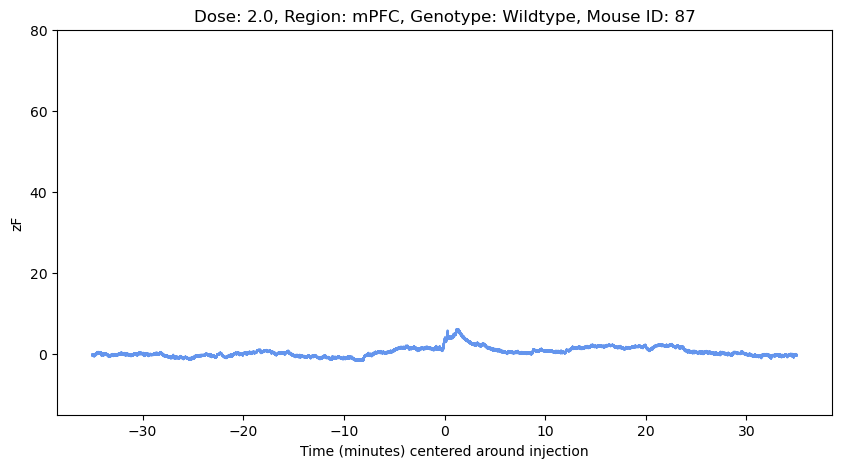

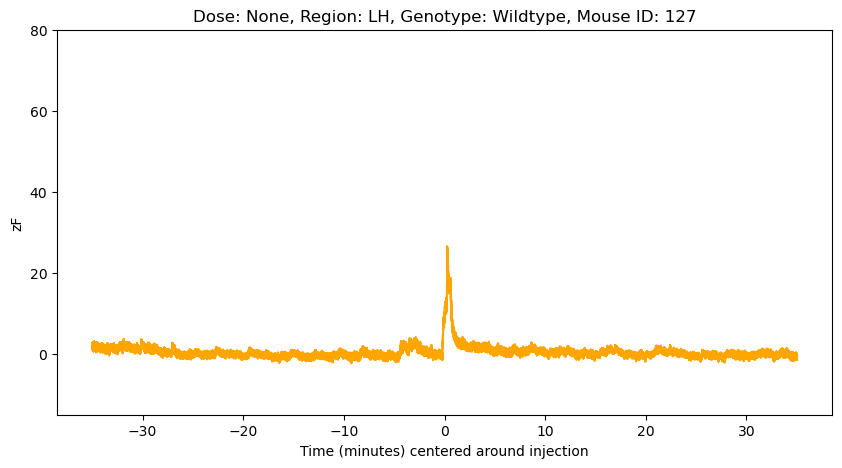

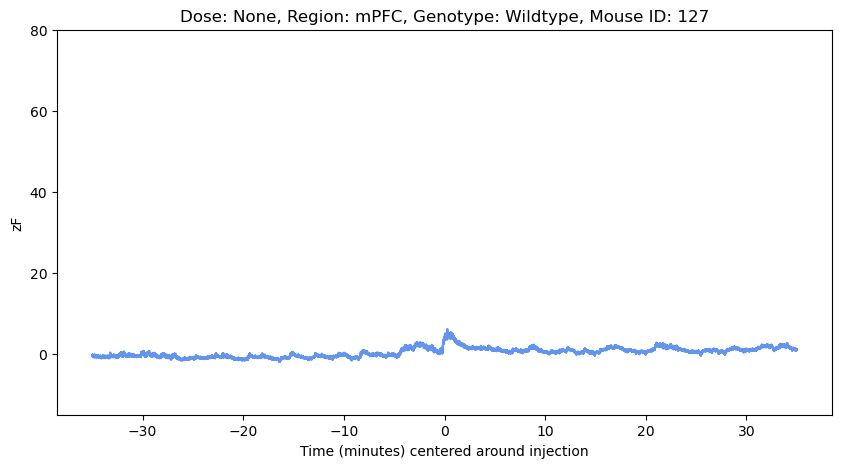

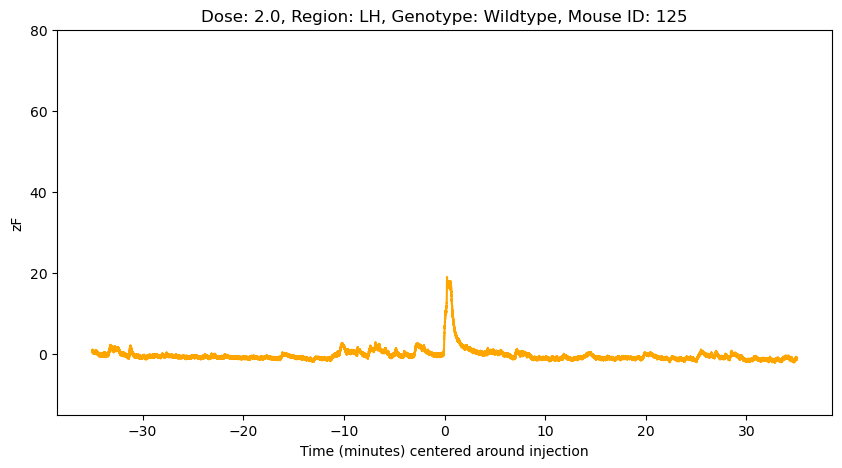

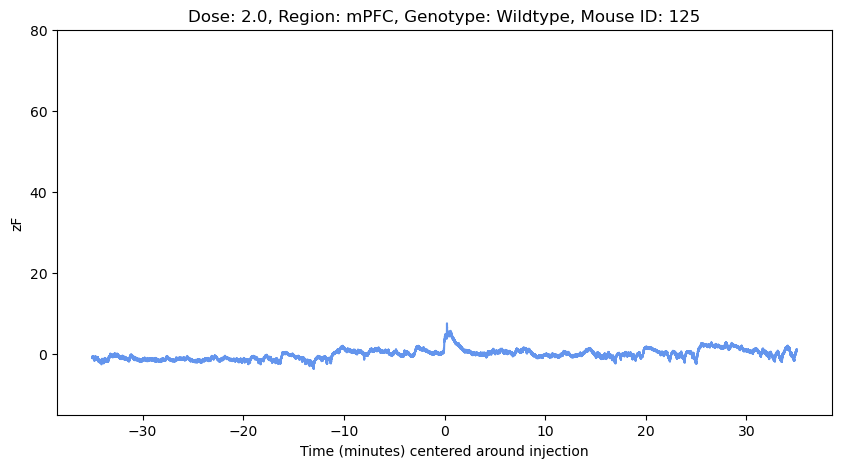

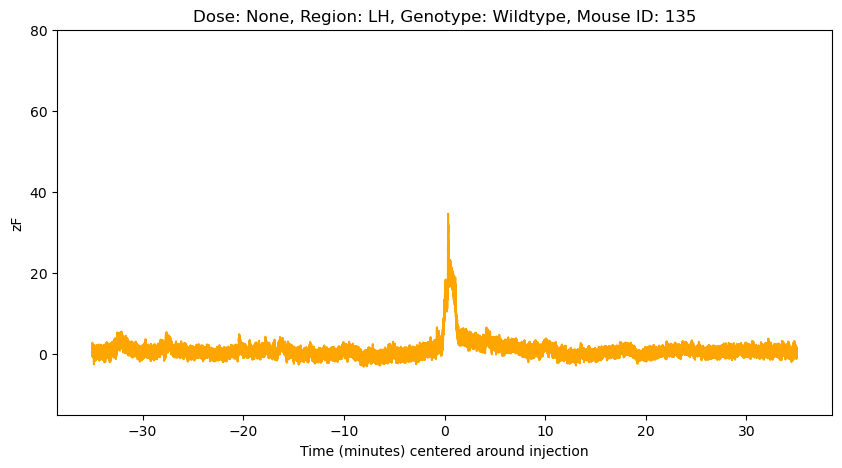

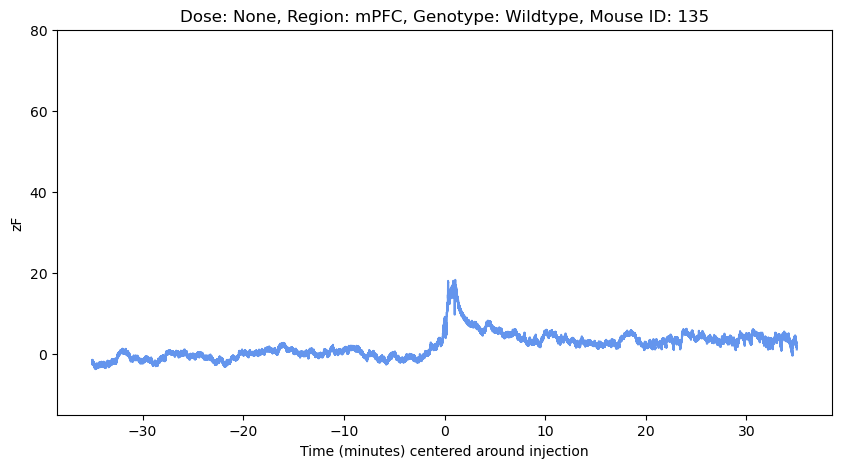

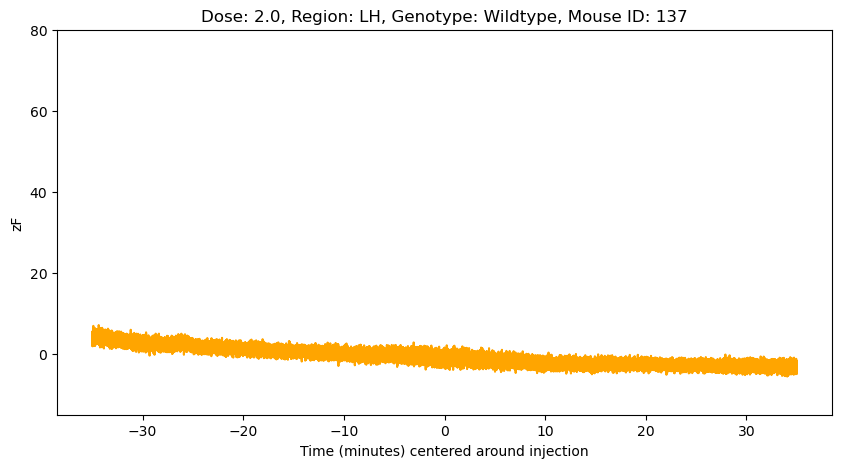

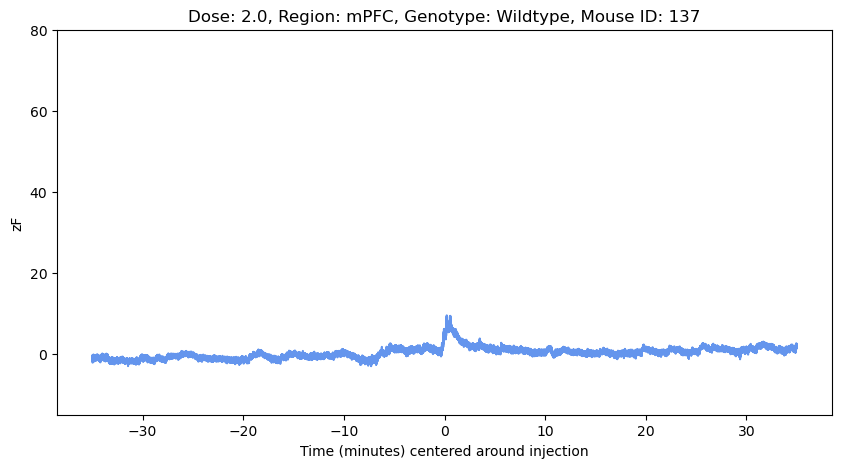

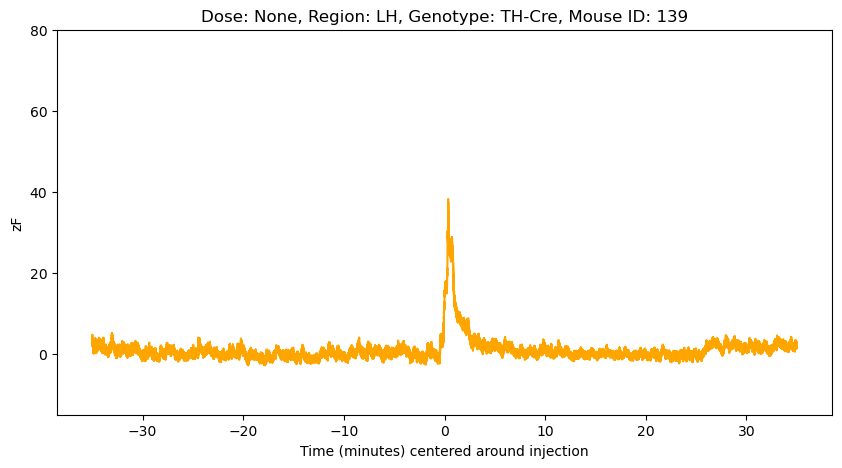

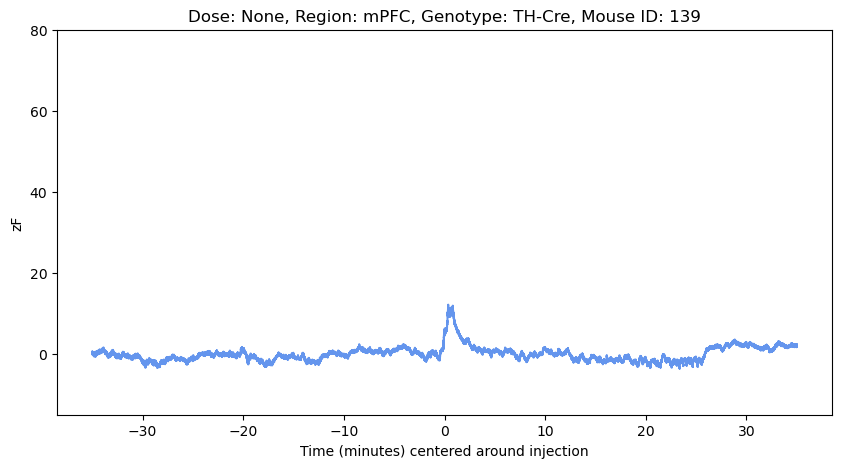

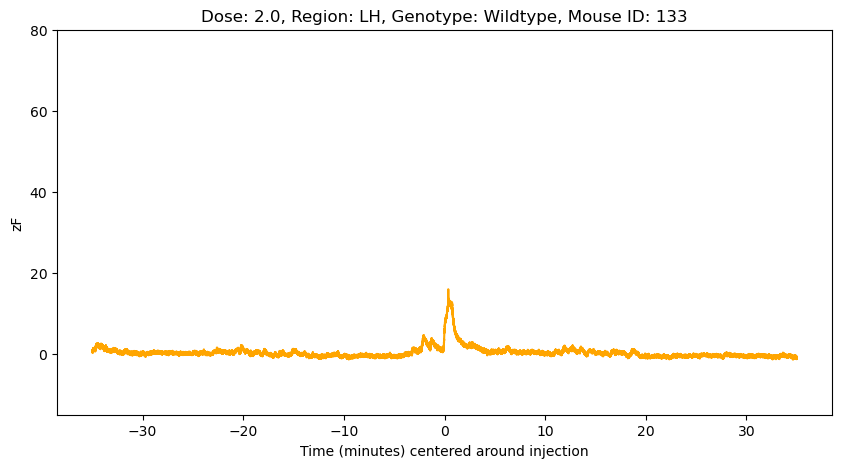

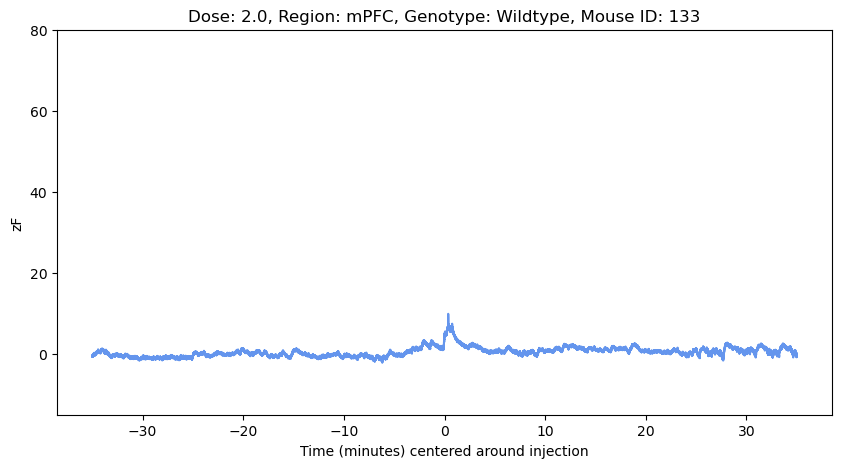

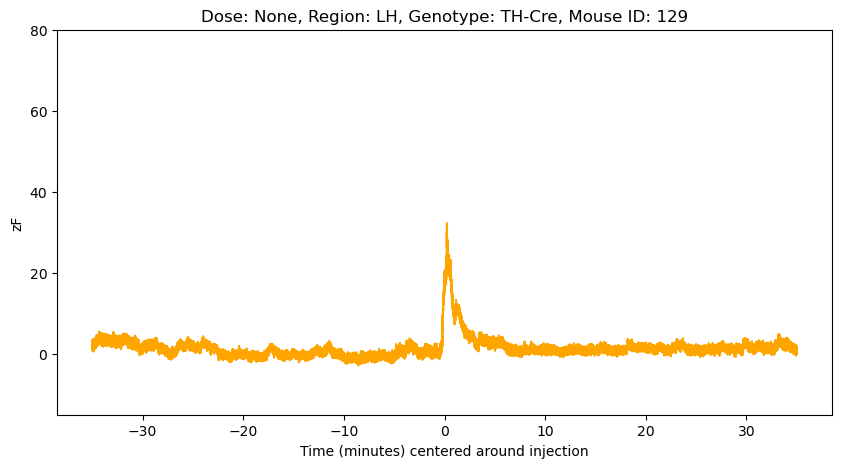

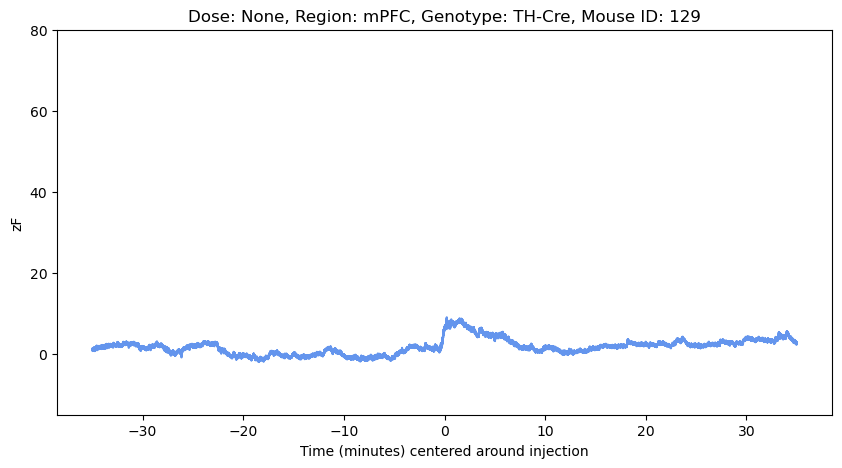

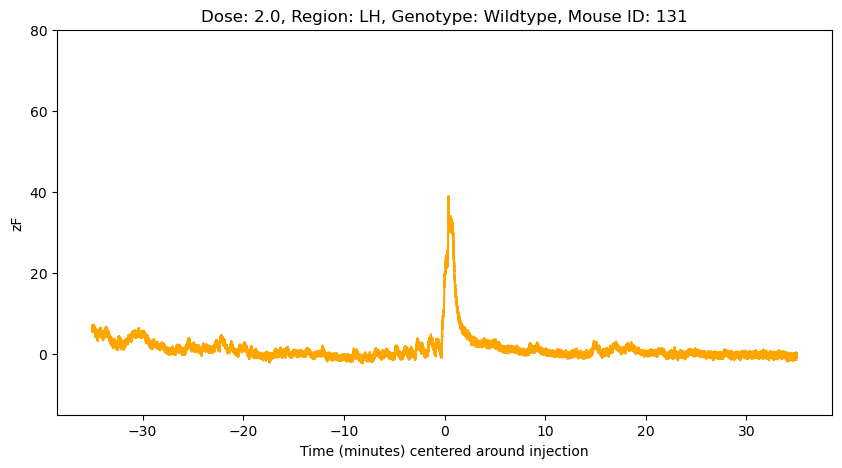

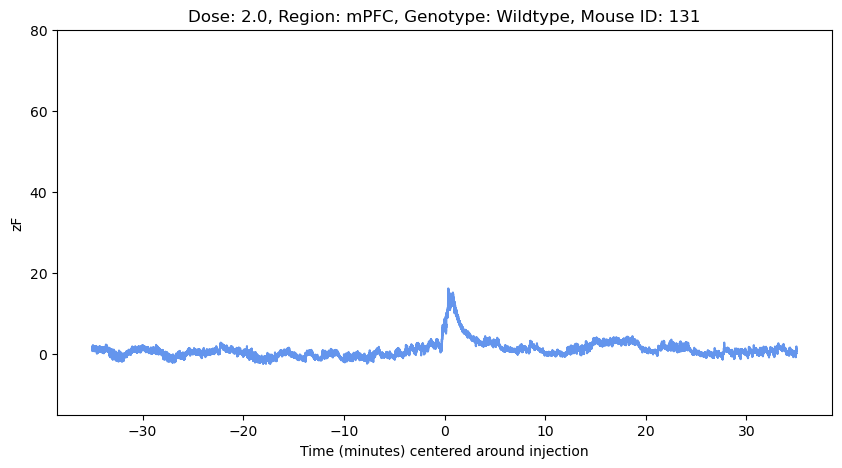

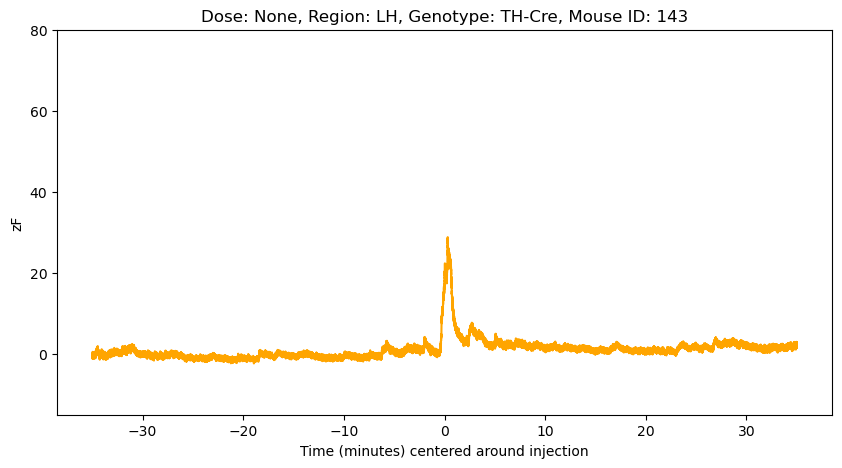

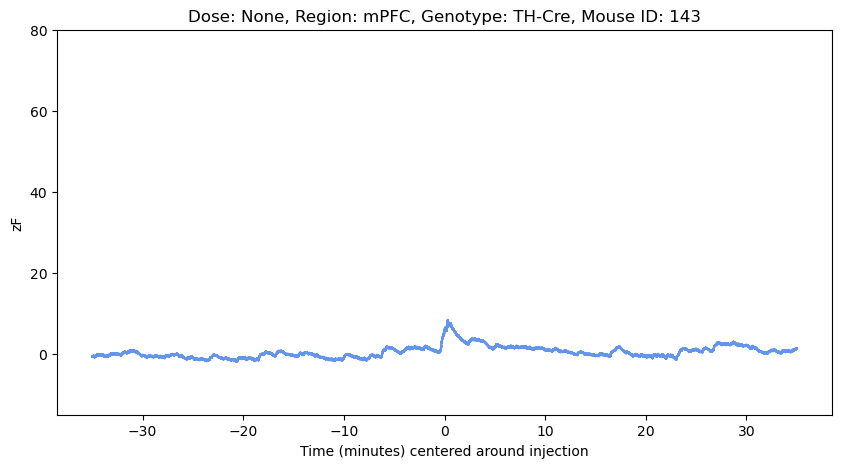

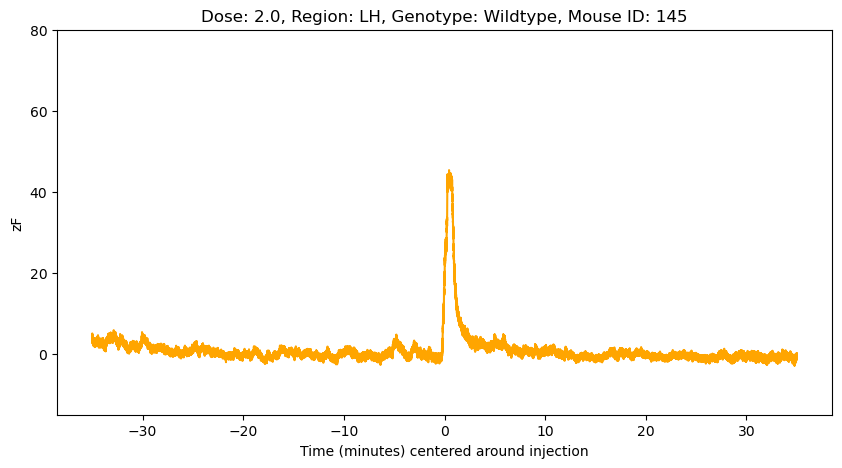

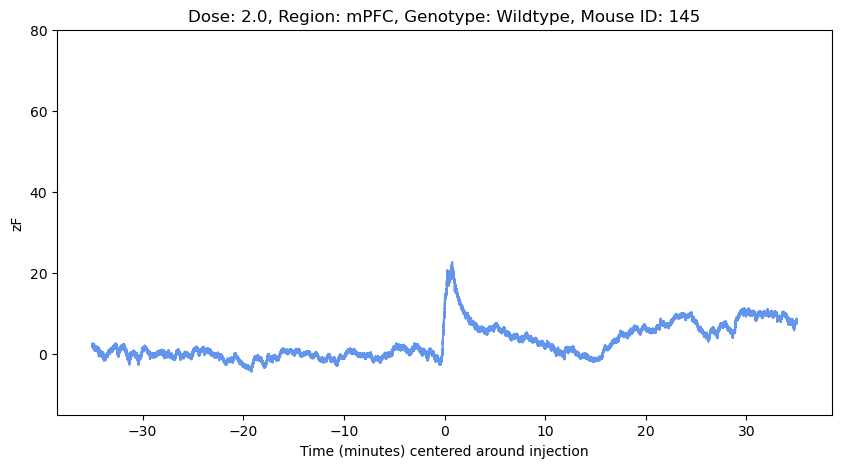

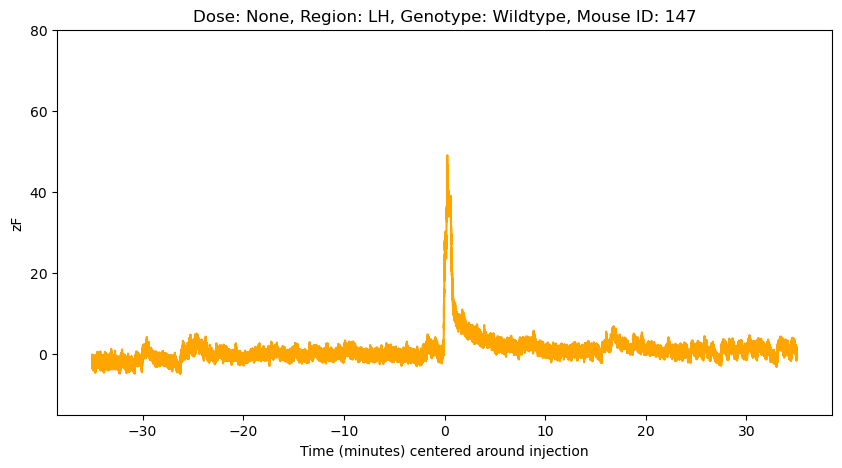

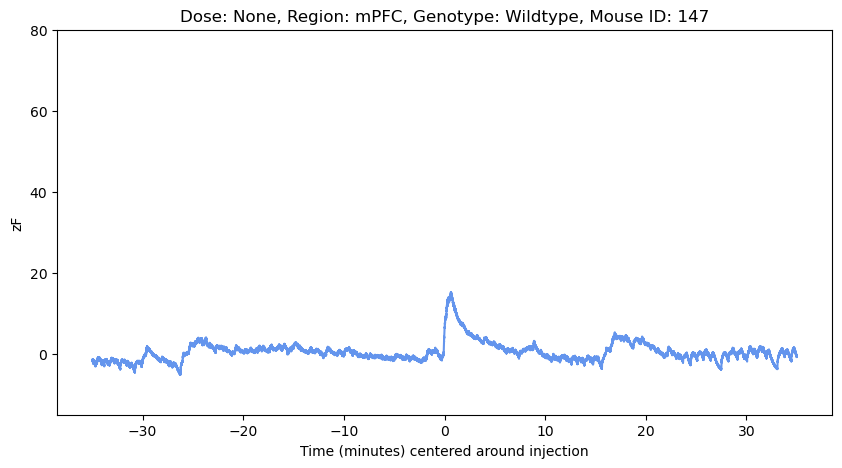

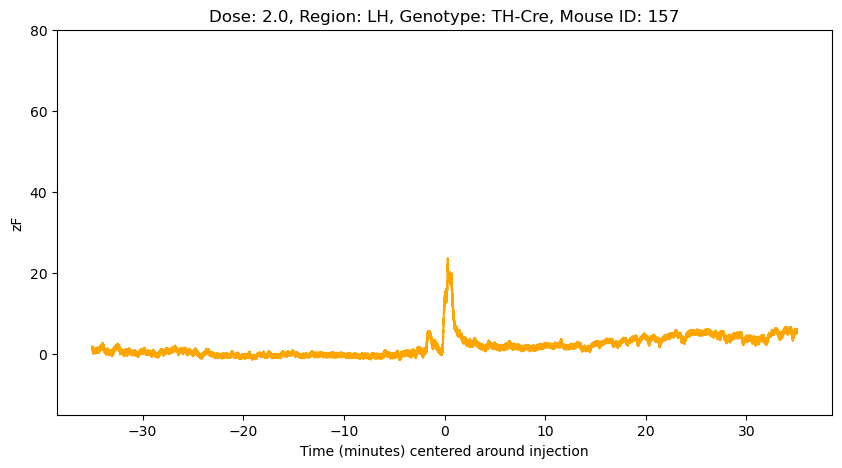

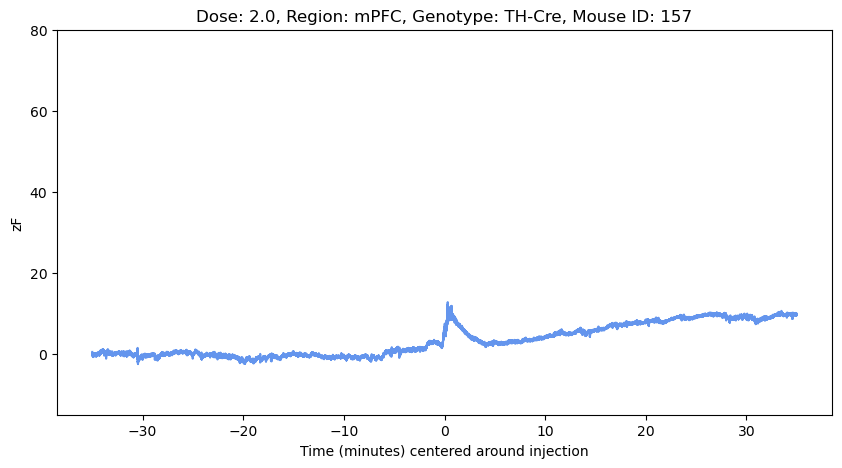

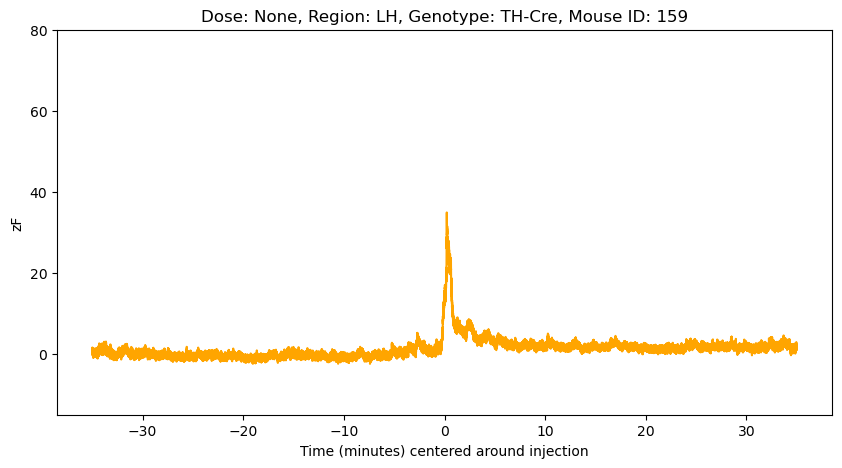

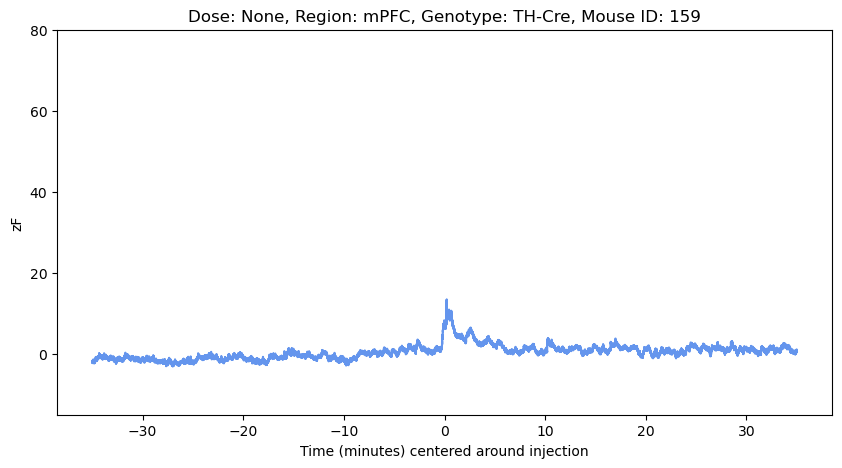

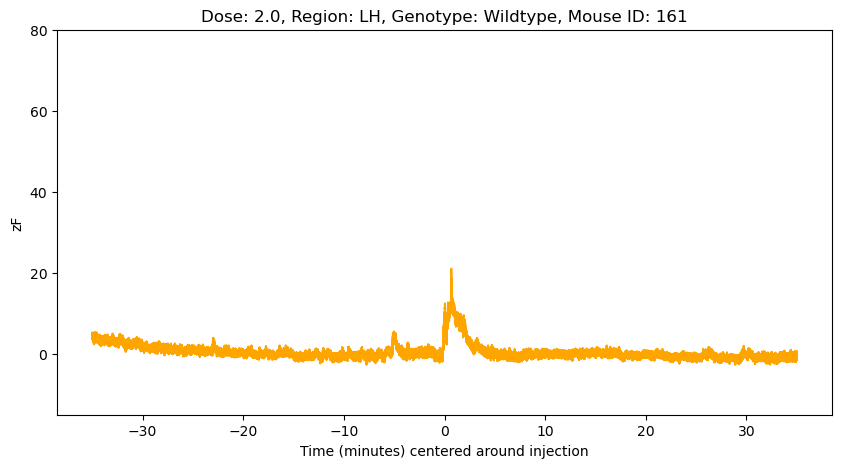

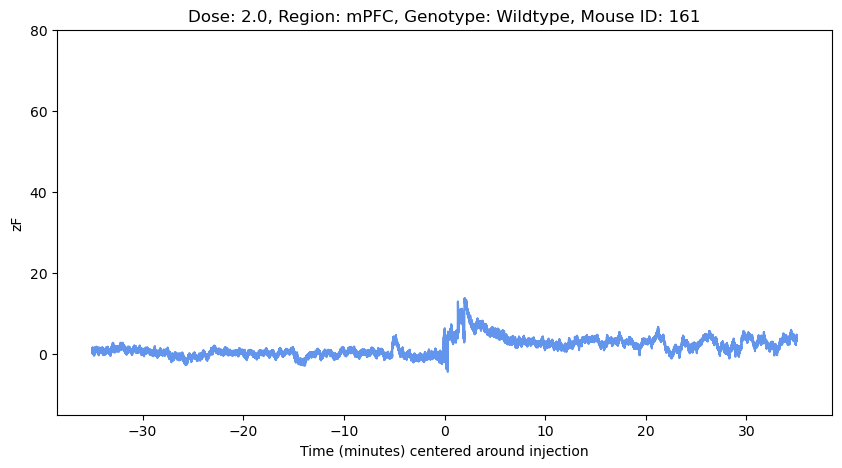

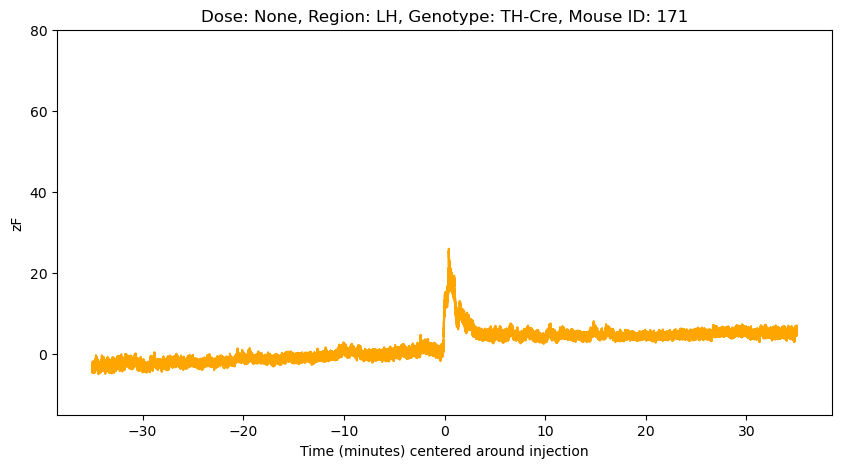

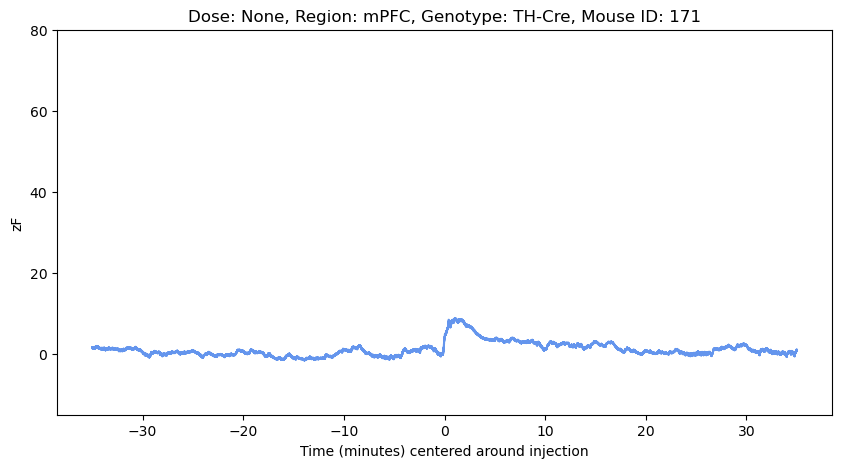

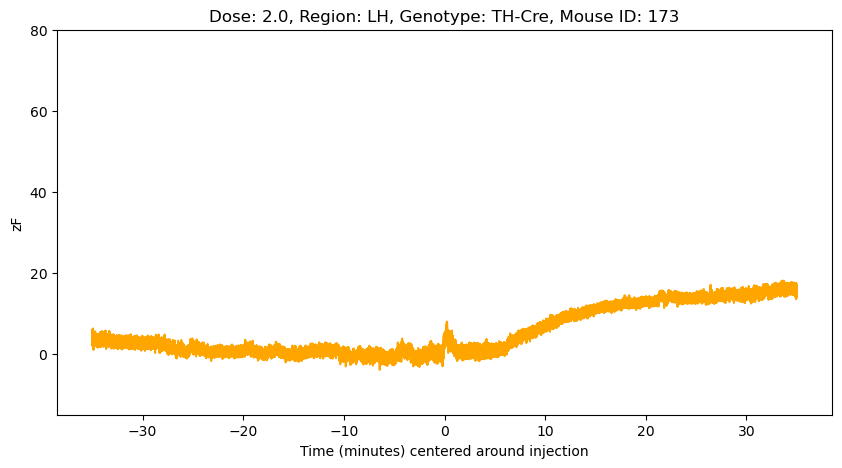

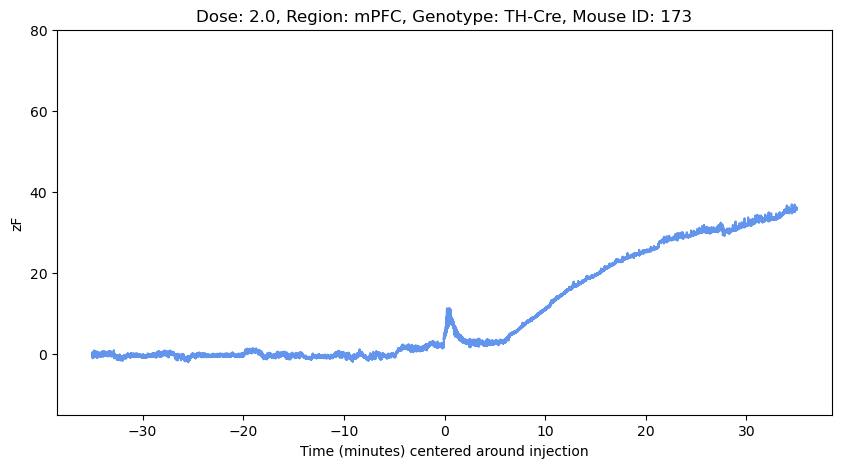

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Step 1: Calculate the overlapping time range across all sessions
min_time = float('-inf')
max_time = float('inf')
fps = 20  # Approximate frames per second

for session in oft_sessions:
    sync_idx = session.trial_start_idx
    timestamps = session.dfs.get_data('phot_470')['Timestamp'] - session.dfs.get_data('phot_470')['Timestamp'].iloc[sync_idx]
    
    # Update overlapping range to the largest common range
    min_time = max(min_time, np.min(timestamps))
    max_time = min(max_time, np.max(timestamps))

# Step 2: Define a common timestamp grid within the overlapping range
resolution = 1 / fps  # 0.05s intervals for 20 Hz
min_time = -35 * 60  # Adjusted to cover 35 minutes before and after injection
max_time = 35 * 60

common_timestamps = np.arange(min_time, max_time, resolution) / 60  # Convert seconds to minutes

for session in oft_sessions:
    sync_idx = session.trial_start_idx
    phot_df = session.dfs.get_data('phot_470')
    dose = session.drug_info['dose']
    genotype = session.genotype  # Assuming session has a `genotype` attribute
    mouse_id = session.mouse_id  # Assuming session has a `mouse_id` attribute
    
    # Center timestamps around sync_idx and crop to the common range
    timestamps = phot_df['Timestamp'] - phot_df['Timestamp'].iloc[sync_idx]
    mask = (timestamps >= min_time) & (timestamps <= max_time)
    cropped_timestamps = timestamps[mask] / 60  # Convert seconds to minutes
    
    for col in phot_df.columns[-2:]:
        brain_region = col if isinstance(col, str) else col[0]  # Adjust if col is a tuple
        signal = phot_df[col].values[mask]  # Crop the signal
    
        # Interpolate cropped signal to the common timestamp grid
        interpolator = interp1d(cropped_timestamps, signal, bounds_error=False, fill_value=np.nan)
        aligned_signal = interpolator(common_timestamps)
    
        brain_reg_to_color = {'LH': 'orange',
                      'mPFC': 'cornflowerblue'}
        curr_color = brain_reg_to_color[brain_region]
        # Plot the aligned signal
        plt.figure(figsize=(10, 5))
        plt.plot(common_timestamps, aligned_signal, color=curr_color)
        #plt.grid()
        plt.ylim(-15, 80)
        plt.xlabel('Time (minutes) centered around injection')  # Updated x-axis label
        plt.ylabel('zF')
        plt.title(f'Dose: {dose}, Region: {brain_region}, Genotype: {genotype}, Mouse ID: {mouse_id}')
        plt.savefig(f'{dose}_{brain_region}_{genotype}_{mouse_id}_fixed.pdf')
        plt.show()

/var/folders/mx/4x3wkj053dg1gcmc9yq87kw00000gn/T/ipykernel_54293/915529906.py:63: RuntimeWarning: Mean of empty slice
  avg_signal = np.nanmean(stacked_signals, axis=0)
/Users/fsp585/anaconda3/envs/sund/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


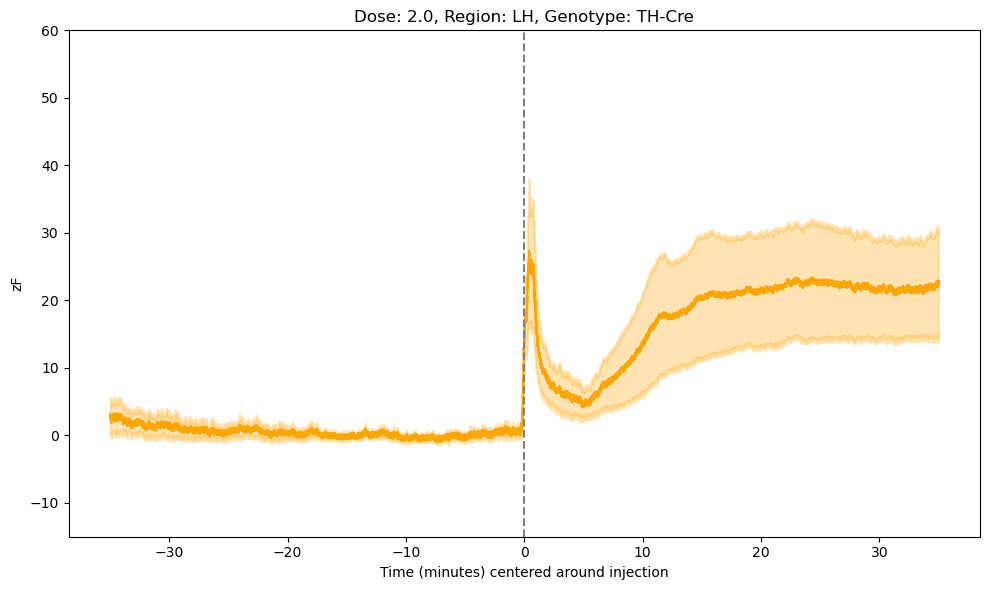

/var/folders/mx/4x3wkj053dg1gcmc9yq87kw00000gn/T/ipykernel_54293/915529906.py:63: RuntimeWarning: Mean of empty slice
  avg_signal = np.nanmean(stacked_signals, axis=0)
/Users/fsp585/anaconda3/envs/sund/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


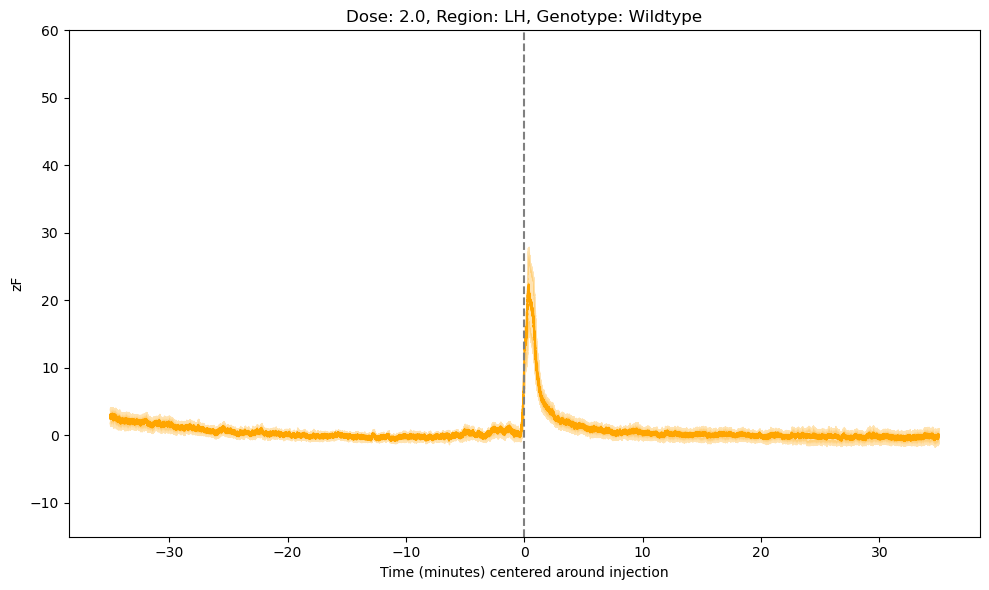

/var/folders/mx/4x3wkj053dg1gcmc9yq87kw00000gn/T/ipykernel_54293/915529906.py:63: RuntimeWarning: Mean of empty slice
  avg_signal = np.nanmean(stacked_signals, axis=0)
/Users/fsp585/anaconda3/envs/sund/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


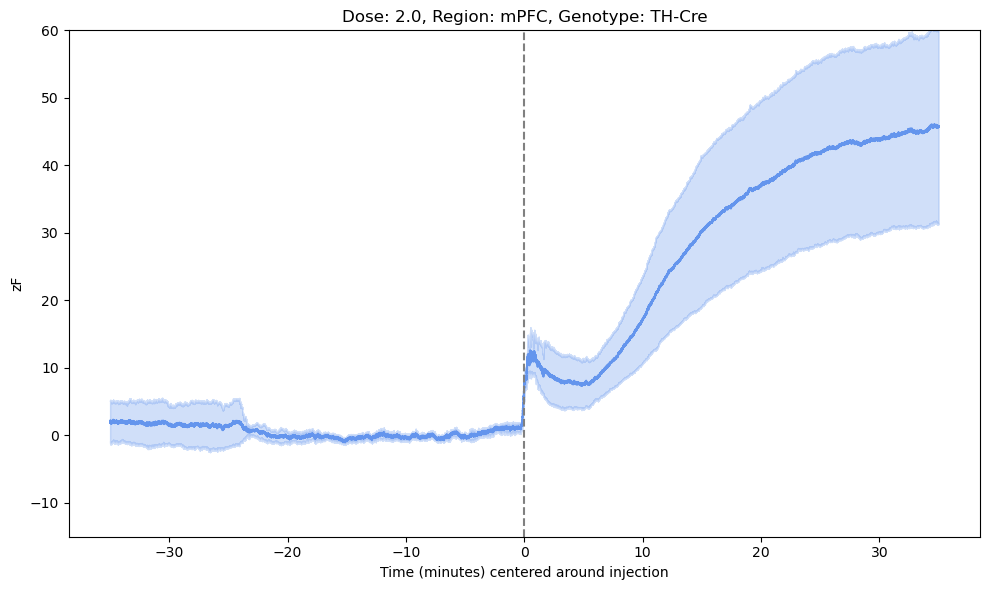

/var/folders/mx/4x3wkj053dg1gcmc9yq87kw00000gn/T/ipykernel_54293/915529906.py:63: RuntimeWarning: Mean of empty slice
  avg_signal = np.nanmean(stacked_signals, axis=0)
/Users/fsp585/anaconda3/envs/sund/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


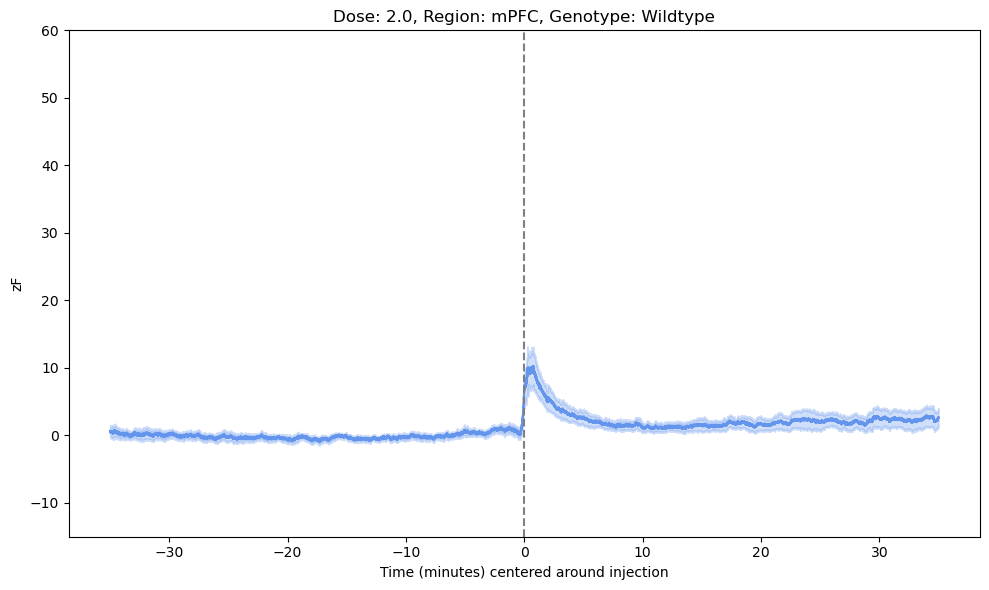

/var/folders/mx/4x3wkj053dg1gcmc9yq87kw00000gn/T/ipykernel_54293/915529906.py:63: RuntimeWarning: Mean of empty slice
  avg_signal = np.nanmean(stacked_signals, axis=0)
/Users/fsp585/anaconda3/envs/sund/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


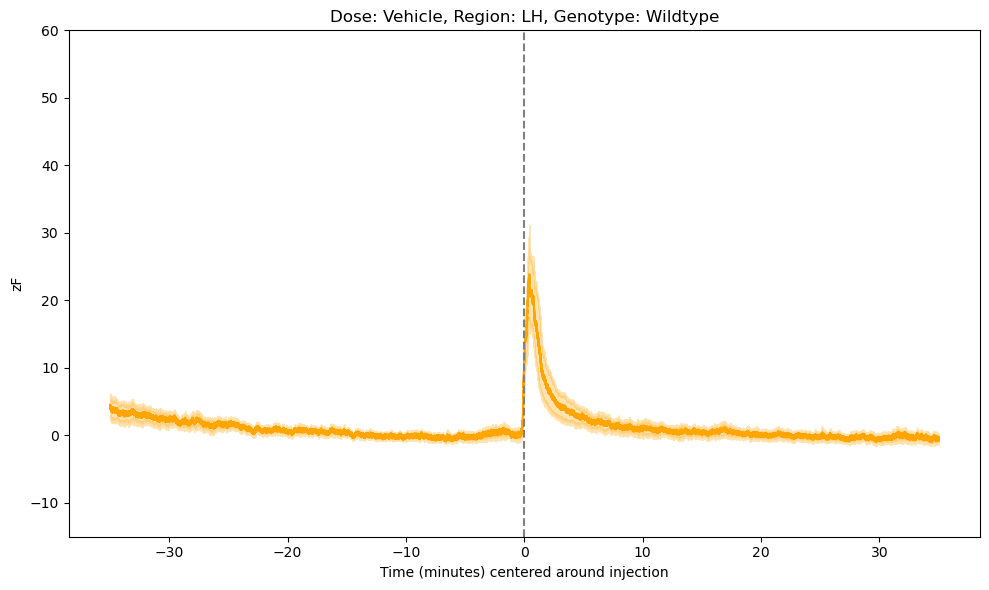

/var/folders/mx/4x3wkj053dg1gcmc9yq87kw00000gn/T/ipykernel_54293/915529906.py:63: RuntimeWarning: Mean of empty slice
  avg_signal = np.nanmean(stacked_signals, axis=0)
/Users/fsp585/anaconda3/envs/sund/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


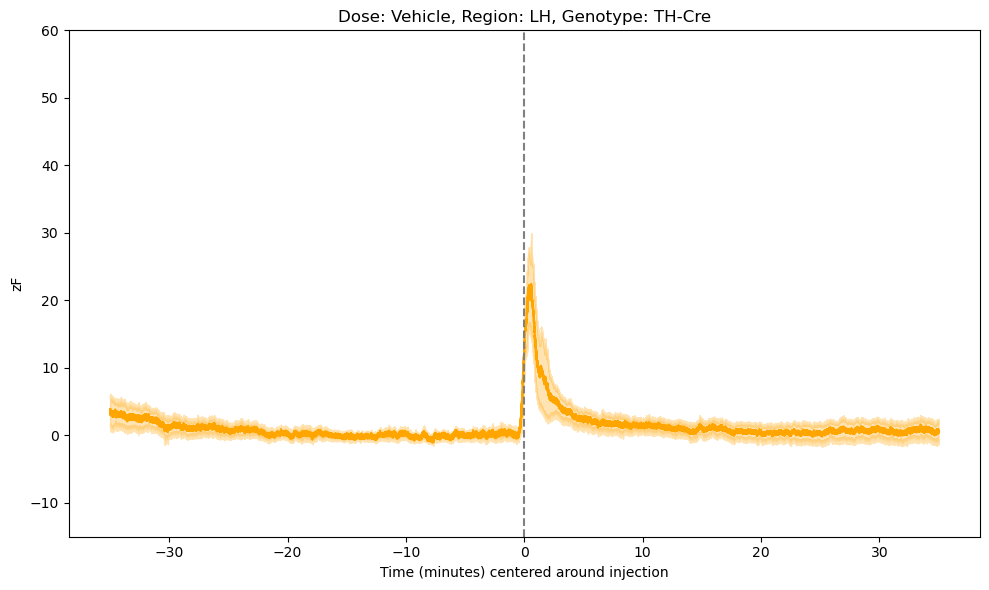

/var/folders/mx/4x3wkj053dg1gcmc9yq87kw00000gn/T/ipykernel_54293/915529906.py:63: RuntimeWarning: Mean of empty slice
  avg_signal = np.nanmean(stacked_signals, axis=0)
/Users/fsp585/anaconda3/envs/sund/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


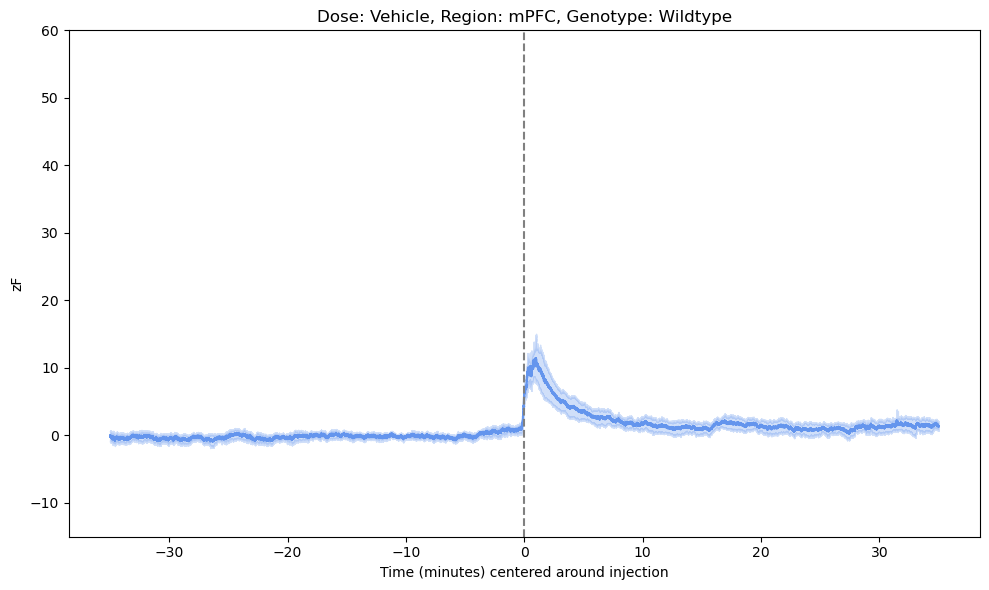

/var/folders/mx/4x3wkj053dg1gcmc9yq87kw00000gn/T/ipykernel_54293/915529906.py:63: RuntimeWarning: Mean of empty slice
  avg_signal = np.nanmean(stacked_signals, axis=0)
/Users/fsp585/anaconda3/envs/sund/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


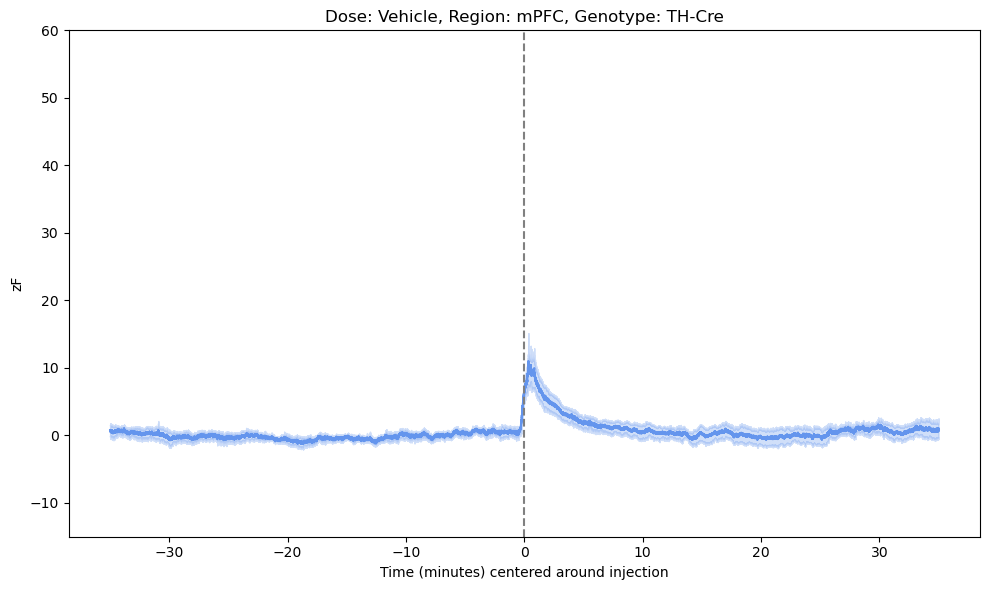

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from collections import defaultdict

# Step 1: Calculate the overlapping time range across all sessions
min_time = float('-inf')
max_time = float('inf')
fps = 20  # Approximate frames per second

for session in oft_sessions:
    sync_idx = session.trial_start_idx
    timestamps = session.dfs.get_data('phot_470')['Timestamp'] - session.dfs.get_data('phot_470')['Timestamp'].iloc[sync_idx]
    
    # Update overlapping range to the largest common range
    min_time = max(min_time, np.min(timestamps))
    max_time = min(max_time, np.max(timestamps))

# Step 2: Define a common timestamp grid within the overlapping range
resolution = 1 / fps  # 0.05s intervals for 20 Hz
min_time = -35 * 60  # in seconds
max_time = 35 * 60   # in seconds

common_timestamps = np.arange(min_time, max_time, resolution) / 60  # Convert to minutes

# Dictionary to store interpolated signals for each (dose, brain_region, genotype) combination
dose_region_genotype_dict = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

# Brain region color mapping
brain_reg_to_color = {
    'LH': 'orange',
    'mPFC': 'cornflowerblue',
    # Add more mappings if necessary
}

for session in oft_sessions:
    sync_idx = session.trial_start_idx
    phot_df = session.dfs.get_data('phot_470')
    dose = session.drug_info['dose']
    genotype = session.genotype  # Assuming session has a `genotype` attribute

    # Center timestamps around sync_idx and crop to the common range
    timestamps = phot_df['Timestamp'] - phot_df['Timestamp'].iloc[sync_idx]
    mask = (timestamps >= min_time) & (timestamps <= max_time)
    cropped_timestamps = timestamps[mask] / 60  # Convert to minutes

    for col in phot_df.columns[-2:]:
        brain_region = col[0]
        signal = phot_df[col].values[mask]  # Crop the signal

        # Interpolate cropped signal to the common timestamp grid
        interpolator = interp1d(cropped_timestamps, signal, bounds_error=False, fill_value=np.nan)
        aligned_signal = interpolator(common_timestamps)  # Already in minutes

        # Store interpolated signal
        dose_region_genotype_dict[dose][brain_region][genotype].append(aligned_signal)

# Plotting with CI95 for each genotype group
for dose, regions in dose_region_genotype_dict.items():
    for brain_region, genotypes in regions.items():
        for genotype, signals in genotypes.items():
            stacked_signals = np.vstack(signals)
            avg_signal = np.nanmean(stacked_signals, axis=0)

            # Calculate CI95
            sem = np.nanstd(stacked_signals, axis=0) / np.sqrt(np.sum(~np.isnan(stacked_signals), axis=0))
            ci95 = 1.96 * sem

            # Determine the color for the current brain region
            curr_color = brain_reg_to_color.get(brain_region, 'gray')  # Default to gray if region not in mapping

            # Plot average signal with CI95
            plt.figure(figsize=(10, 6))
            plt.plot(common_timestamps, avg_signal, label=f'Dose: {dose}, Region: {brain_region}, Genotype: {genotype}', color=curr_color)
            plt.fill_between(common_timestamps, avg_signal - ci95, avg_signal + ci95, color=curr_color, alpha=0.3)

            plt.axvline(x=0, color='gray', linestyle='--')
            plt.ylim(-15, 60)
            plt.xlabel('Time (minutes) centered around injection')
            plt.ylabel('zF')
            #plt.grid()
            dose_title = dose
            if dose is None:
                dose_title = 'Vehicle'
            plt.title(f'Dose: {dose_title}, Region: {brain_region}, Genotype: {genotype}')
            plt.tight_layout()
            plt.savefig(f'session_average_{dose}_{brain_region}_{genotype}.pdf')
            plt.savefig(f'session_average_{dose}_{brain_region}_{genotype}.png')
            plt.show()


/var/folders/mx/4x3wkj053dg1gcmc9yq87kw00000gn/T/ipykernel_54293/4131101611.py:90: RuntimeWarning: Mean of empty slice
  avg_signal = np.nanmean(stacked_signals, axis=0)
/Users/fsp585/anaconda3/envs/sund/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


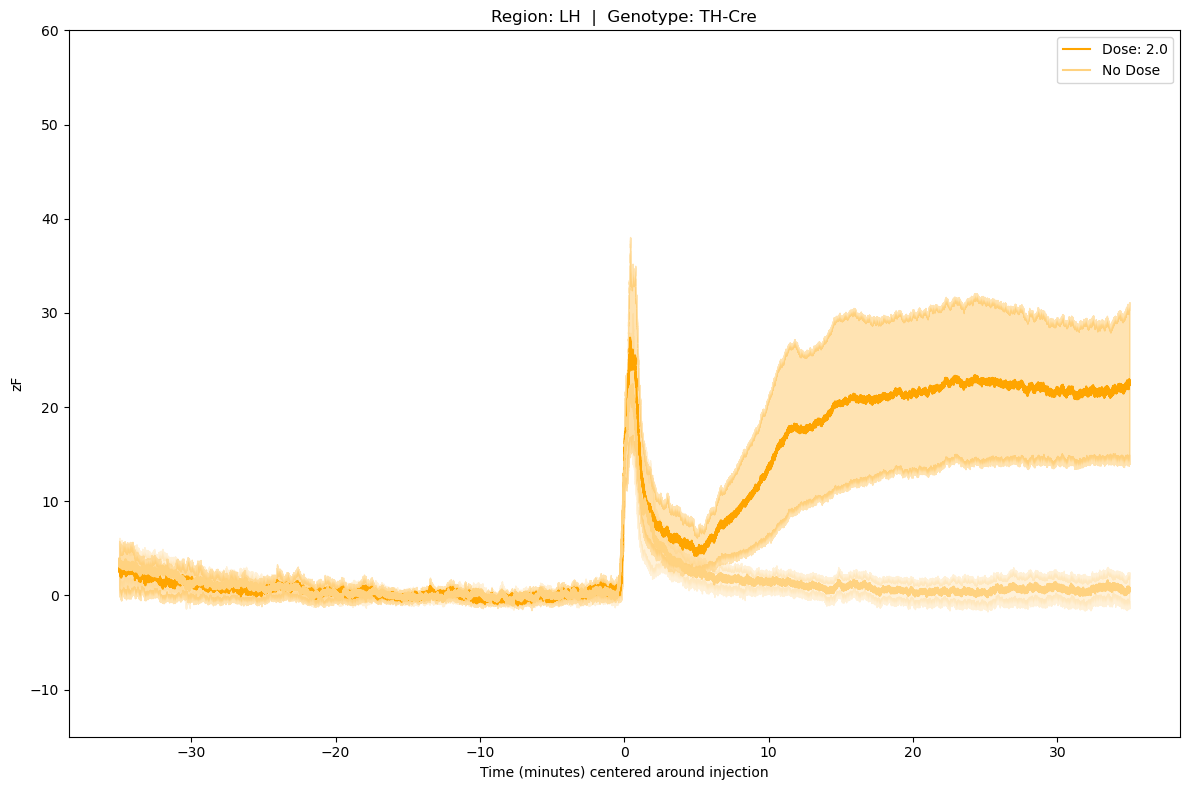

/var/folders/mx/4x3wkj053dg1gcmc9yq87kw00000gn/T/ipykernel_54293/4131101611.py:90: RuntimeWarning: Mean of empty slice
  avg_signal = np.nanmean(stacked_signals, axis=0)
/Users/fsp585/anaconda3/envs/sund/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


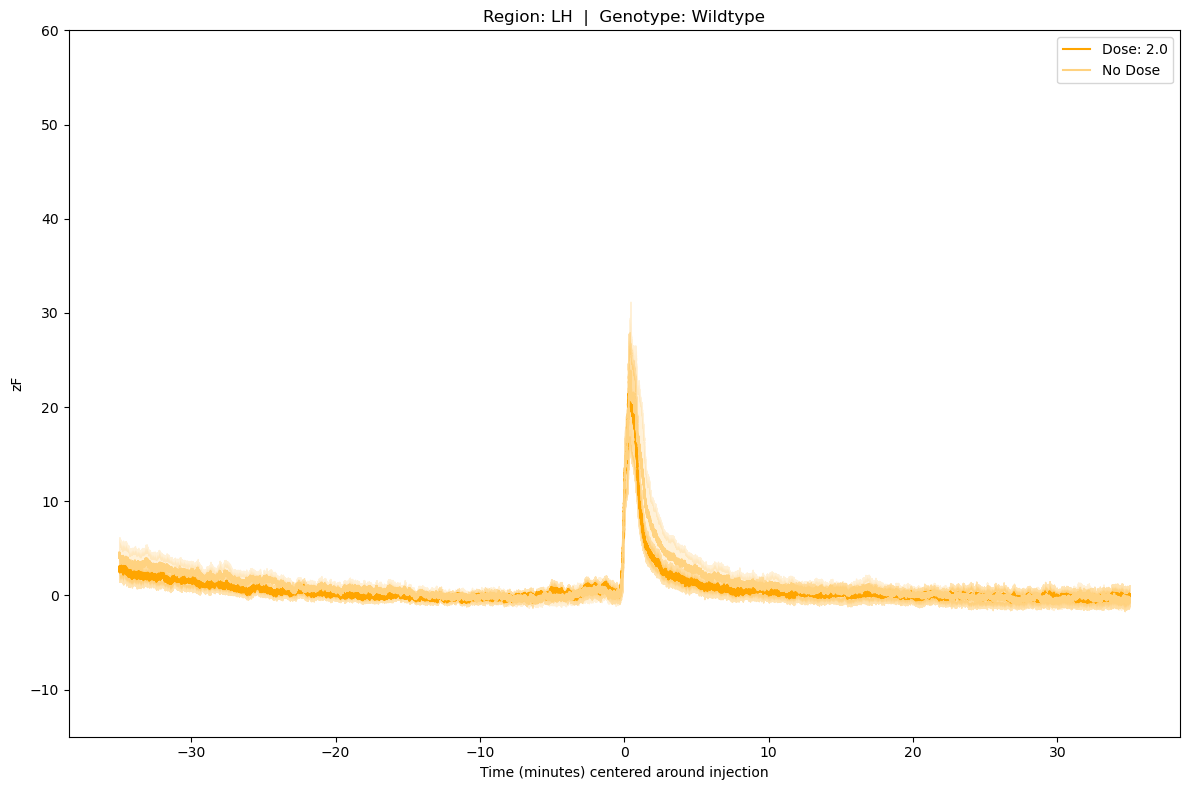

/var/folders/mx/4x3wkj053dg1gcmc9yq87kw00000gn/T/ipykernel_54293/4131101611.py:90: RuntimeWarning: Mean of empty slice
  avg_signal = np.nanmean(stacked_signals, axis=0)
/Users/fsp585/anaconda3/envs/sund/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


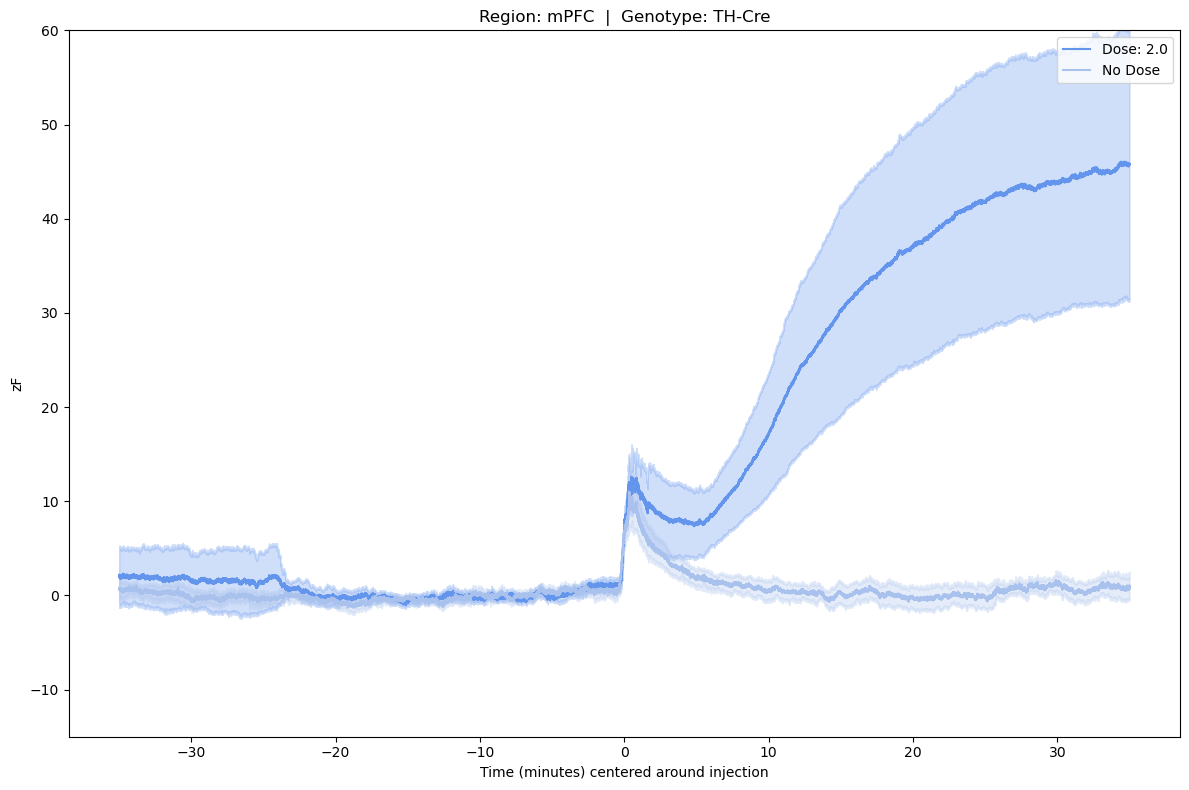

/var/folders/mx/4x3wkj053dg1gcmc9yq87kw00000gn/T/ipykernel_54293/4131101611.py:90: RuntimeWarning: Mean of empty slice
  avg_signal = np.nanmean(stacked_signals, axis=0)
/Users/fsp585/anaconda3/envs/sund/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


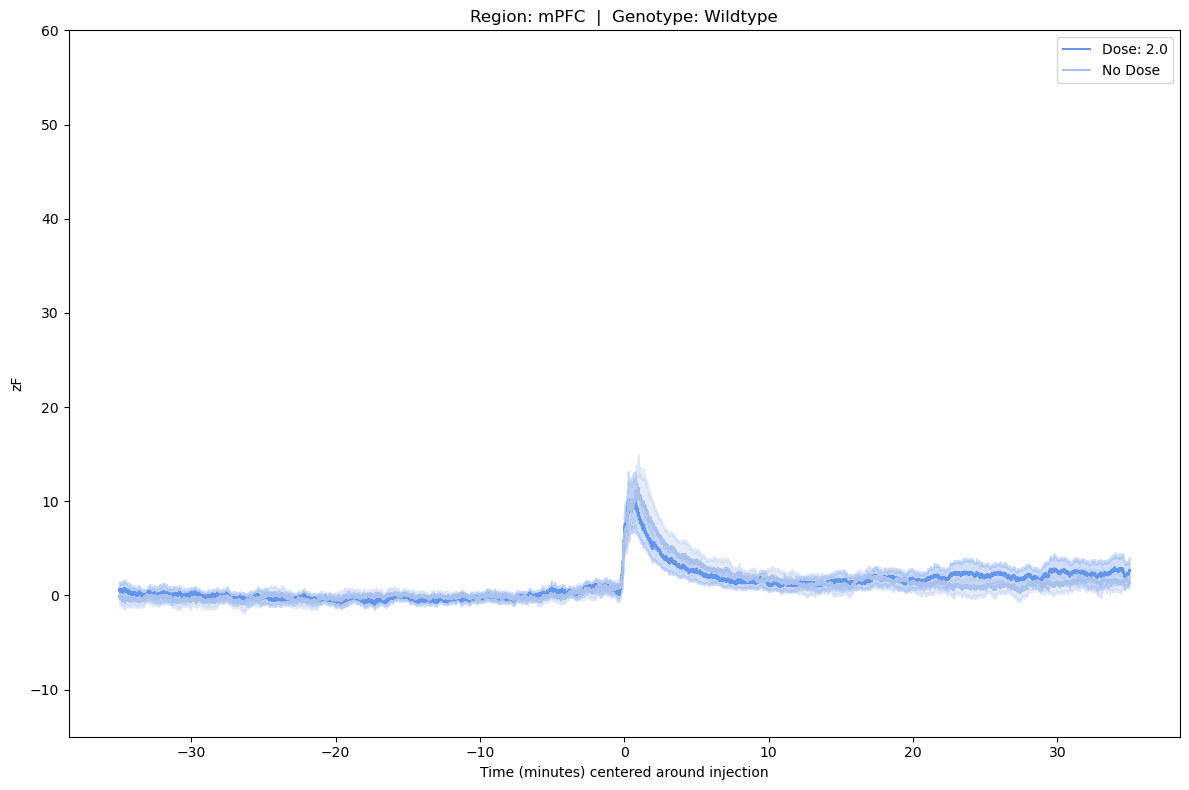

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from collections import defaultdict
import matplotlib.colors as mcolors
import colorsys

# Helper function: adjust the saturation of a color by a given factor.
def adjust_saturation(color, factor):
    """
    Adjusts the saturation of a color.
    :param color: A matplotlib color string or RGB tuple.
    :param factor: Multiplicative factor for saturation (e.g., 0.5 gives less saturation).
    :return: New color in RGB tuple.
    """
    rgb = mcolors.to_rgb(color)
    hsv = colorsys.rgb_to_hsv(*rgb)
    new_hsv = (hsv[0], min(1, hsv[1] * factor), hsv[2])
    return colorsys.hsv_to_rgb(*new_hsv)

# Reset matplotlib settings (optional)
plt.rcdefaults()

# Step 1: Calculate the overlapping time range across all sessions
min_time = float('-inf')
max_time = float('inf')
fps = 20  # Approximate frames per second

for session in oft_sessions:
    sync_idx = session.trial_start_idx
    timestamps = session.dfs.get_data('phot_470')['Timestamp'] - session.dfs.get_data('phot_470')['Timestamp'].iloc[sync_idx]
    min_time = max(min_time, np.min(timestamps))
    max_time = min(max_time, np.max(timestamps))

# Step 2: Define a common timestamp grid within the overlapping range
resolution = 1 / fps  # 0.05s intervals for 20 Hz
min_time = -35 * 60  # in seconds
max_time = 35 * 60   # in seconds

# Create common timestamps in minutes
common_timestamps = np.arange(min_time, max_time, resolution) / 60  # Convert seconds to minutes

# Dictionary to store interpolated signals for each (dose, brain_region, genotype) combination
dose_region_genotype_dict = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

# Base color mapping for brain regions (full saturation)
brain_reg_to_color = {
    'LH': 'orange',
    'mPFC': 'cornflowerblue',
}

# Process each session and interpolate signals
for session in oft_sessions:
    sync_idx = session.trial_start_idx
    phot_df = session.dfs.get_data('phot_470')
    dose = session.drug_info['dose']
    genotype = session.genotype  # Assuming session has a `genotype` attribute

    # Center timestamps around sync_idx and crop to the common range
    timestamps = phot_df['Timestamp'] - phot_df['Timestamp'].iloc[sync_idx]
    mask = (timestamps >= min_time) & (timestamps <= max_time)
    cropped_timestamps = timestamps[mask] / 60  # Convert to minutes

    # Process each signal column (assuming the last two columns are the ones to plot)
    for col in phot_df.columns[-2:]:
        brain_region = col[0] if isinstance(col, tuple) else col
        signal = phot_df[col].values[mask]
        # Interpolate the cropped signal to the common timestamp grid (in minutes)
        interpolator = interp1d(cropped_timestamps, signal, bounds_error=False, fill_value=np.nan)
        aligned_signal = interpolator(common_timestamps)
        # Store the interpolated signal
        dose_region_genotype_dict[dose][brain_region][genotype].append(aligned_signal)

# Combined Plot: For each brain region and genotype, plot the signals for different dose conditions in a single plot.
# The only difference is color saturation: full saturation for dose and less saturated for no dose.
for brain_region in brain_reg_to_color.keys():
    # Gather all available genotypes for this brain region from any dose entry.
    genotypes_set = set()
    for dose_val, regions in dose_region_genotype_dict.items():
        if brain_region in regions:
            genotypes_set.update(regions[brain_region].keys())
    
    for genotype in sorted(genotypes_set):
        plt.figure(figsize=(12, 8))
        # Iterate over dose values for this brain region and genotype
        for curr_dose, region_data in dose_region_genotype_dict.items():
            if brain_region in region_data and genotype in region_data[brain_region]:
                signals = region_data[brain_region][genotype]
                stacked_signals = np.vstack(signals)
                avg_signal = np.nanmean(stacked_signals, axis=0)
                
                # Calculate CI95 (optional)
                sem = np.nanstd(stacked_signals, axis=0) / np.sqrt(np.sum(~np.isnan(stacked_signals), axis=0))
                ci95 = 1.96 * sem
                
                label_text = f"{'No Dose' if curr_dose is None or curr_dose == '' else f'Dose: {curr_dose}'}"
                
                # Use full saturation for dose-present sessions and lower saturation for no dose.
                base_color = brain_reg_to_color.get(brain_region, 'gray')
                curr_color = base_color if curr_dose not in [None, ''] else adjust_saturation(base_color, 0.5)
                
                # Plot without explicitly specifying a linestyle so that the default solid line is used.
                plt.plot(common_timestamps, avg_signal,
                         label=label_text,
                         color=curr_color)
                plt.fill_between(common_timestamps, avg_signal - ci95, avg_signal + ci95,
                                 color=curr_color, alpha=0.3)
        
        plt.axvline(x=0, color='gray', linestyle='--')
        plt.ylim(-15, 60)
        plt.xlabel('Time (minutes) centered around injection')
        plt.ylabel('zF')
        plt.title(f'Region: {brain_region}  |  Genotype: {genotype}')
        #plt.grid()
        #plt.legend()
        plt.tight_layout()
        plt.savefig(f"session_averages_grouped_{brain_region}_{genotype}_no_grid_legend.pdf")
        plt.savefig(f"session_averages_grouped_{brain_region}_{genotype}_no_grid_legend.png")
        plt.show()
